## Overview
An on demand delivery company thrives by making customers happy.

*If they can predict what makes customers happy or unhappy, they can take the necessary actions.*

**Recent survey data subset:**  

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers  
X1 = my order was delivered on time  
X2 = contents of my order was as I expected  
X3 = I ordered everything I wanted to order  
X4 = I paid a good price for my order  
X5 = I am satisfied with my courier  
X6 = the app makes ordering easy for me  

*X values from 1 to 5 where 5 is most positive and 1 is most negative.*

**Goals:**  

*Predict (e.g., >75% accuracy) if a customer is happy or not based on the answers they give to questions asked.* 

*Identify which questions are more/less important when predicting a customer’s happiness.*  

## Imports

In [205]:
# Standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (GradientBoostingClassifier, RandomForestClassifier, 
                              ExtraTreesClassifier, VotingClassifier)
import lightgbm as lgb

# For hyperparameter tuning
from sklearn.model_selection import (train_test_split, GridSearchCV, RandomizedSearchCV)

# For implementation
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import (SelectFromModel, SelectKBest, chi2)

# For evaluation
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score)
from sklearn.metrics import (roc_curve, auc)

# For quickly testing models
from pycaret.classification import (setup, compare_models)

# Statistics
from scipy import stats
from scipy.stats import yeojohnson

# Feature inspection
from sklearn.inspection import permutation_importance

## Load data and explore

In [2]:
df = pd.read_csv('survey.csv')
print('Shape is', df.shape)
df.head(3)

Shape is (126, 7)


,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5


In [3]:
# Rename columns using info from OVERVIEW

# X1 = my order was delivered on time  
# X2 = contents of my order was as I expected  
# X3 = I ordered everything I wanted to order  
# X4 = I paid a good price for my order  
# X5 = I am satisfied with my courier  
# X6 = the app makes ordering easy for me  

old_cols = list(df.columns)
new_cols = ['customer_happiness', 'on_time', 'expected_content','order_everything', 'good_price', 
           'good_courier', 'good_app']

df.rename(columns=dict(zip(old_cols, new_cols)), inplace=True)
df.head()

,customer_happiness,on_time,expected_content,order_everything,good_price,good_courier,good_app
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [4]:
df.dtypes

customer_happiness    int64
on_time               int64
expected_content      int64
order_everything      int64
good_price            int64
good_courier          int64
good_app              int64
dtype: object

In [5]:
# Are there any nans?

df.isna().sum()

customer_happiness    0
on_time               0
expected_content      0
order_everything      0
good_price            0
good_courier          0
good_app              0
dtype: int64

In [6]:
# Are any values outside the 0-1 and 1-5 ranges?
# What are the basic statistics for each feature?

df.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_happiness,126.0,0.547619,0.499714,0.0,0.0,1.0,1.0,1.0
on_time,126.0,4.333333,0.800000,1.0,4.0,5.0,5.0,5.0
expected_content,126.0,2.531746,1.114892,1.0,2.0,3.0,3.0,5.0
order_everything,126.0,3.309524,1.023440,1.0,3.0,3.0,4.0,5.0
good_price,126.0,3.746032,0.875776,1.0,3.0,4.0,4.0,5.0
good_courier,126.0,3.650794,1.147641,1.0,3.0,4.0,4.0,5.0
good_app,126.0,4.253968,0.809311,1.0,4.0,4.0,5.0,5.0


Performance-wise (mean > 4), the company is delivering on_time and has an good_app that's easy to use. The expected contents of each order seems to be less reliable. 

In [7]:
# Group by customer happiness and check average response from each survey question

df_grouped = df.groupby('customer_happiness').agg('mean')
df_grouped

,on_time,expected_content,order_everything,good_price,good_courier,good_app
customer_happiness,,,,,,
0,4.087719,2.561404,3.140351,3.684211,3.368421,4.105263
1,4.536232,2.507246,3.449275,3.797101,3.884058,4.376812


The average rating was higher among happy customers for all features except expected_content, which barely changed. Therefore, it may be that this feature is unimportant for our predictive model.

## Visualize data distributions

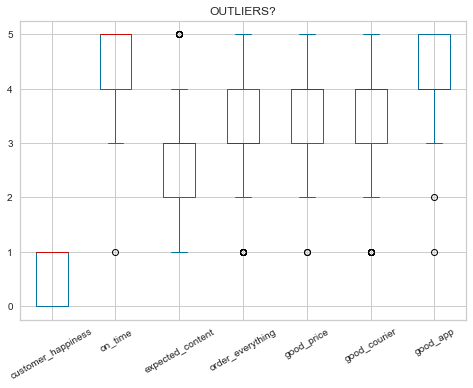

In [8]:
# Are there many outliers?

df.plot(kind='box', title='OUTLIERS?')
plt.xticks(rotation=30)
plt.show()

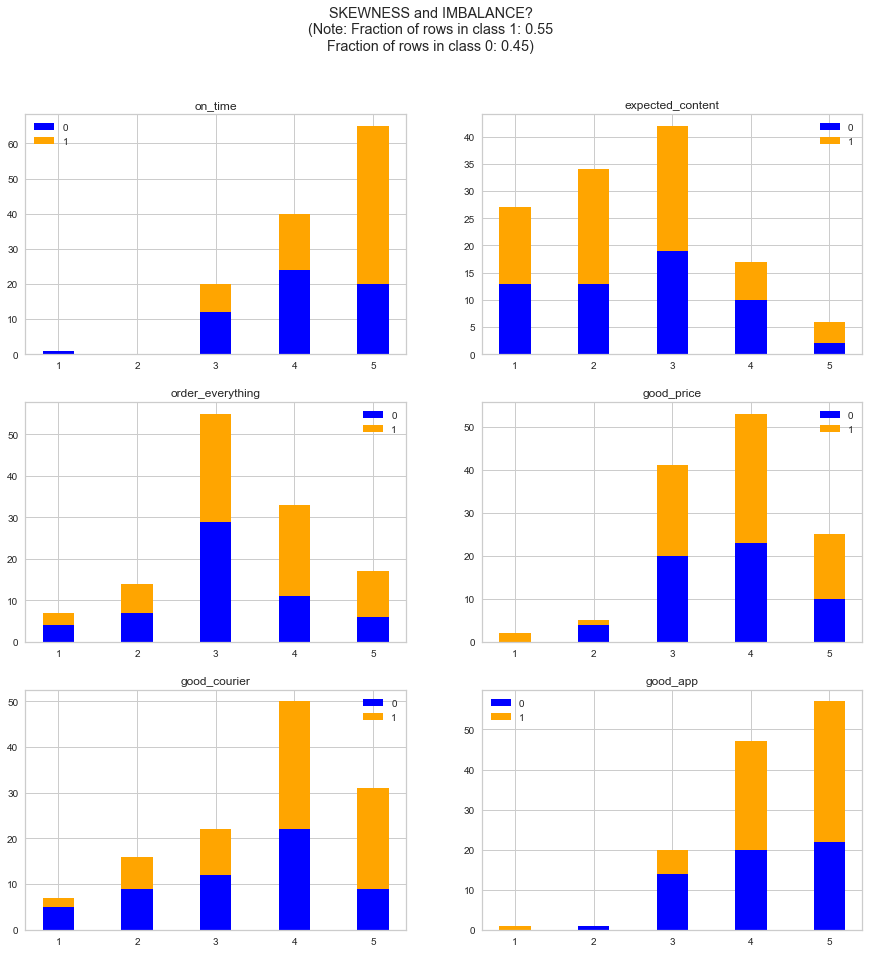

In [9]:
# Are the classes (happy = 1, unhappy = 0) balanced?
# Are the data normally distributed?

imbtitle = (f'SKEWNESS and IMBALANCE?\n(Note: Fraction of rows in class '
            f'{df.customer_happiness.value_counts(normalize=True).index[0]}: '
            f'{df.customer_happiness.value_counts(normalize=True).iloc[0]:.2}\n'
            f'Fraction of rows in class {df.customer_happiness.value_counts(normalize=True).index[1]}: '
            f'{df.customer_happiness.value_counts(normalize=True).iloc[1]:.2})')

fig, axs = plt.subplots(3, 2, figsize=(15,15))

for i in range(3):
    for j in range(2):
        df_plot = df.groupby(df.columns[(2*i+1+j)])['customer_happiness'].value_counts().unstack().fillna(0)
        
        axs[i, j].bar(df_plot.index, 
                      df_plot.iloc[:,0],
                      label=f'{df_plot.columns[0]}', 
                      width=0.4, 
                      color='blue')
        axs[i, j].bar(df_plot.index, 
                      df_plot.iloc[:,1], 
                      bottom=df_plot.iloc[:,0],
                      label=f'{df_plot.columns[1]}', 
                      width=0.4, 
                      color='orange')
        axs[i, j].set_title(df.columns[(2*i+1+j)])
        axs[i, j].legend()

        fig.suptitle(imbtitle)
plt.show()

There are more happy (55%) than unhappy (45%) customers.  

The plots align with the average ratings we viewed earlier. Deliveries are usually on_time and the good_app is easy to use. We see that ratings of 4 and 5 from these features is more often associated with the happy category (1, not 0). Although the expected_content might not be the main driver for customer_happiness, it clearly shows room for improvement.

Statistically speaking, we see that some survey results are not distributed normally: expected_content is slightly skewed right, while the others are skewed left (although order_everything is almost normal).

In [10]:
# Calculation of feature skewness

skew_vals = df.drop(columns=['customer_happiness']).skew()
skew_vals.sort_values(ascending = False)

expected_content    0.271000
order_everything   -0.199536
good_price         -0.422240
good_courier       -0.699999
good_app           -0.957590
on_time            -1.058468
dtype: float64

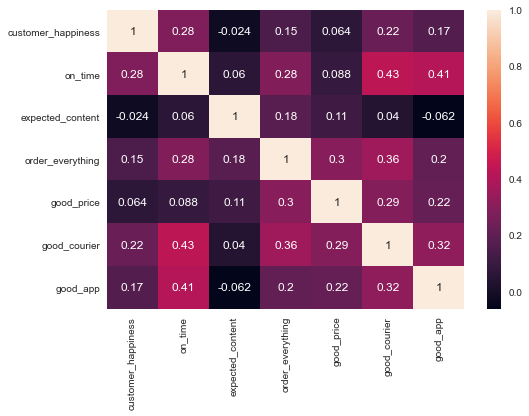

In [11]:
# Create correlation matrix

corr = df.corr()
sns.heatmap(corr, annot = True)
plt.show()

Again, we see that expected_content may not help our predictive model since it has a very low correlation with customer_happiness. Good_price also isn't strongly correlated with customer_happiness (surprisingly).

## Feature engineering

In [12]:
# Remove some skewness via the Yeo Johnson transformation

time_tra, time_lambda = yeojohnson(df['on_time'])
price_tra, price_lambda = yeojohnson(df['good_price'])
courier_tra, courier_lambda = yeojohnson(df['good_courier'])
app_tra, app_lambda = yeojohnson(df['good_app'])

# New dataframe

df_tra = df.copy()
df_tra['on_time'] = time_tra
df_tra['good_price'] = price_tra
df_tra['good_courier'] = courier_tra
df_tra['good_app'] = app_tra

# Recalculation of feature skewness

skew_vals = df_tra.drop(columns=['customer_happiness']).skew()
skew_vals.sort_values(ascending = False)

expected_content    0.271000
good_price         -0.040459
order_everything   -0.199536
good_courier       -0.223615
good_app           -0.258052
on_time            -0.362614
dtype: float64

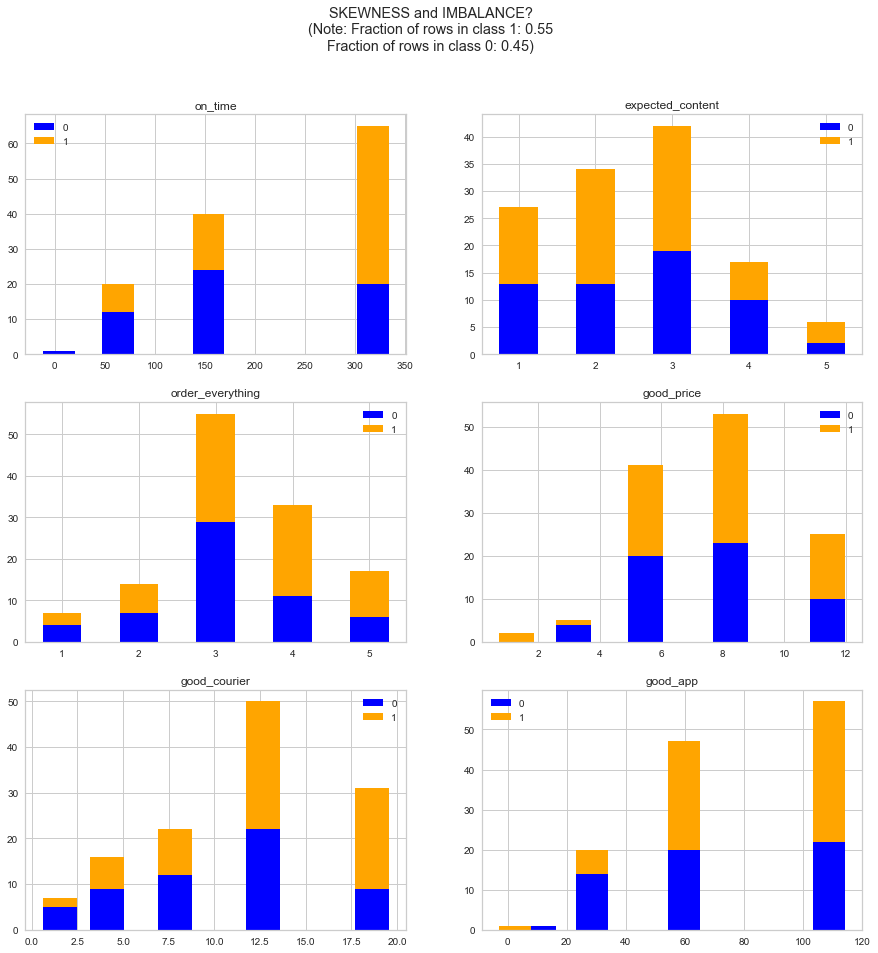

In [13]:
# Replot the distributions to look at skewness after the transformation

imbtitle = (f'SKEWNESS and IMBALANCE?\n(Note: Fraction of rows in class '
            f'{df_tra.customer_happiness.value_counts(normalize=True).index[0]}: '
            f'{df_tra.customer_happiness.value_counts(normalize=True).iloc[0]:.2}\n'
            f'Fraction of rows in class {df_tra.customer_happiness.value_counts(normalize=True).index[1]}: '
            f'{df_tra.customer_happiness.value_counts(normalize=True).iloc[1]:.2})')

fig, axs = plt.subplots(3, 2, figsize=(15,15))

for i in range(3):
    for j in range(2):
        df_plot = df_tra.groupby(df_tra.columns[(2*i+1+j)])['customer_happiness'].value_counts().unstack().fillna(0)
        
        axs[i, j].bar(df_plot.index, 
                      df_plot.iloc[:,0],
                      label=f'{df_plot.columns[0]}', 
                      # Scale bar width to x-axis
                      width=0.1*df_plot.index.max(), 
                      color='blue')
        axs[i, j].bar(df_plot.index, 
                      df_plot.iloc[:,1], 
                      bottom=df_plot.iloc[:,0],
                      label=f'{df_plot.columns[1]}', 
                      # Scale bar width to x-axis
                      width=0.1*df_plot.index.max(), 
                      color='orange')
        axs[i, j].set_title(df.columns[(2*i+1+j)])
        axs[i, j].legend()

        fig.suptitle(imbtitle)
plt.show()

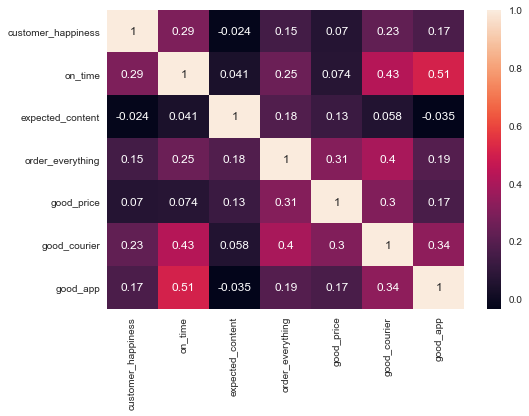

In [14]:
# Replot correlation matrix

corr_tra = df_tra.corr()
sns.heatmap(corr_tra, annot = True)
plt.show()

Correlation went up slightly for good_price, so it shows some promise.  

We will try three different datasets:  
1. all data, 
2. all data except expected_content, 
3. and all data except expected_content and good_price.

In [100]:
# Entire dataset

df1 = pd.get_dummies(df_tra, 
                     columns = [
                          'on_time', 
                          'expected_content', 
                          'order_everything', 
                          'good_price', 
                          'good_courier', 
                          'good_app'], 
                     drop_first = False)

# Dataset minus expected_content

df2 = df_tra.drop(columns=['expected_content'])

df2 = pd.get_dummies(df_tra, 
                     columns = [
                          'on_time', 
                          'order_everything', 
                          'good_price', 
                          'good_courier', 
                          'good_app'], 
                     drop_first = False)

# Dataset minus expected_content and good_price

df3 = df_tra.drop(columns=['expected_content', 'good_price'])

df3 = pd.get_dummies(df_tra, 
                     columns = [
                          'on_time', 
                          'order_everything', 
                          'good_courier', 
                          'good_app'], 
                     drop_first = False)

## Model exploration

In [101]:
# Although pycaret will perform a train, test split, we should set aside an
# "official test set" beforehand to facilitate a rigorous evaluation of our final model.
# Thus, pycaret will be splittng the training set.

# Train, test split for all 3 datasets

y_1 = df1['customer_happiness'].to_numpy()
X_1 = df1.iloc[:,1:].to_numpy()
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y_1, test_size=0.3, random_state=333)

y_2 = df2['customer_happiness'].to_numpy()
X_2 = df2.iloc[:,1:].to_numpy()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y_2, test_size=0.3, random_state=333)

y_3 = df3['customer_happiness'].to_numpy()
X_3 = df3.iloc[:,1:].to_numpy()
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_3, y_3, test_size=0.3, random_state=333)

In [102]:
# Build 3 dataframes from training sets for pycaret testing of models

df_train1 = pd.DataFrame(X_train1)
df_train1['Y'] = y_train1

df_train2 = pd.DataFrame(X_train2)
df_train2['Y'] = y_train2

df_train3 = pd.DataFrame(X_train3)
df_train3['Y'] = y_train3

In [103]:
# Setup pycaret and compare models for full dataset

s = setup(df_train1, target='Y', html=False, silent=True, verbose=False)
best = compare_models()
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7214,0.7417,0.8083,0.7433,0.7529,0.4417,0.4652,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7214,0.7417,0.8083,0.7433,0.7529,0.4417,0.4652,0.006
knn,K Neighbors Classifier,0.6571,0.6681,0.7167,0.7017,0.6700,0.3160,0.3475,0.012


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7214,0.7417,0.8083,0.7433,0.7529,0.4417,0.4652,0.006
nb,Naive Bayes,0.7071,0.7639,0.7833,0.7117,0.7300,0.4160,0.4475,0.006
knn,K Neighbors Classifier,0.6571,0.6681,0.7167,0.7017,0.6700,0.3160,0.3475,0.012


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7214,0.7417,0.8083,0.7433,0.7529,0.4417,0.4652,0.006
nb,Naive Bayes,0.7071,0.7639,0.7833,0.7117,0.7300,0.4160,0.4475,0.006
knn,K Neighbors Classifier,0.6571,0.6681,0.7167,0.7017,0.6700,0.3160,0.3475,0.012
dt,Decision Tree Classifier,0.6214,0.7069,0.5250,0.6817,0.5519,0.2462,0.2742,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7214,0.7417,0.8083,0.7433,0.7529,0.4417,0.4652,0.006
nb,Naive Bayes,0.7071,0.7639,0.7833,0.7117,0.7300,0.4160,0.4475,0.006
svm,SVM - Linear Kernel,0.6881,0.0000,0.7083,0.7450,0.7110,0.3655,0.3723,0.006
knn,K Neighbors Classifier,0.6571,0.6681,0.7167,0.7017,0.6700,0.3160,0.3475,0.012
dt,Decision Tree Classifier,0.6214,0.7069,0.5250,0.6817,0.5519,0.2462,0.2742,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7214,0.7417,0.8083,0.7433,0.7529,0.4417,0.4652,0.006
nb,Naive Bayes,0.7071,0.7639,0.7833,0.7117,0.7300,0.4160,0.4475,0.006
svm,SVM - Linear Kernel,0.6881,0.0000,0.7083,0.7450,0.7110,0.3655,0.3723,0.006
ridge,Ridge Classifier,0.6881,0.0000,0.7500,0.7317,0.7155,0.3750,0.3838,0.006
knn,K Neighbors Classifier,0.6571,0.6681,0.7167,0.7017,0.6700,0.3160,0.3475,0.012
dt,Decision Tree Classifier,0.6214,0.7069,0.5250,0.6817,0.5519,0.2462,0.2742,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7214,0.7417,0.8083,0.7433,0.7529,0.4417,0.4652,0.006
nb,Naive Bayes,0.7071,0.7639,0.7833,0.7117,0.7300,0.4160,0.4475,0.006
rf,Random Forest Classifier,0.7071,0.7222,0.7167,0.7167,0.6924,0.4160,0.4255,0.088
svm,SVM - Linear Kernel,0.6881,0.0000,0.7083,0.7450,0.7110,0.3655,0.3723,0.006
ridge,Ridge Classifier,0.6881,0.0000,0.7500,0.7317,0.7155,0.3750,0.3838,0.006
knn,K Neighbors Classifier,0.6571,0.6681,0.7167,0.7017,0.6700,0.3160,0.3475,0.012
dt,Decision Tree Classifier,0.6214,0.7069,0.5250,0.6817,0.5519,0.2462,0.2742,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7214,0.7417,0.8083,0.7433,0.7529,0.4417,0.4652,0.006
nb,Naive Bayes,0.7071,0.7639,0.7833,0.7117,0.7300,0.4160,0.4475,0.006
rf,Random Forest Classifier,0.7071,0.7222,0.7167,0.7167,0.6924,0.4160,0.4255,0.088
svm,SVM - Linear Kernel,0.6881,0.0000,0.7083,0.7450,0.7110,0.3655,0.3723,0.006
ridge,Ridge Classifier,0.6881,0.0000,0.7500,0.7317,0.7155,0.3750,0.3838,0.006
knn,K Neighbors Classifier,0.6571,0.6681,0.7167,0.7017,0.6700,0.3160,0.3475,0.012
dt,Decision Tree Classifier,0.6214,0.7069,0.5250,0.6817,0.5519,0.2462,0.2742,0.006
qda,Quadratic Discriminant Analysis,0.5905,0.5611,0.7500,0.6067,0.6548,0.1827,0.1719,0.007


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7214,0.7417,0.8083,0.7433,0.7529,0.4417,0.4652,0.006
nb,Naive Bayes,0.7071,0.7639,0.7833,0.7117,0.7300,0.4160,0.4475,0.006
rf,Random Forest Classifier,0.7071,0.7222,0.7167,0.7167,0.6924,0.4160,0.4255,0.088
svm,SVM - Linear Kernel,0.6881,0.0000,0.7083,0.7450,0.7110,0.3655,0.3723,0.006
ridge,Ridge Classifier,0.6881,0.0000,0.7500,0.7317,0.7155,0.3750,0.3838,0.006
ada,Ada Boost Classifier,0.6714,0.6389,0.6917,0.7483,0.6917,0.3483,0.3550,0.027
knn,K Neighbors Classifier,0.6571,0.6681,0.7167,0.7017,0.6700,0.3160,0.3475,0.012
dt,Decision Tree Classifier,0.6214,0.7069,0.5250,0.6817,0.5519,0.2462,0.2742,0.006
qda,Quadratic Discriminant Analysis,0.5905,0.5611,0.7500,0.6067,0.6548,0.1827,0.1719,0.007


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7214,0.7417,0.8083,0.7433,0.7529,0.4417,0.4652,0.006
nb,Naive Bayes,0.7071,0.7639,0.7833,0.7117,0.7300,0.4160,0.4475,0.006
rf,Random Forest Classifier,0.7071,0.7222,0.7167,0.7167,0.6924,0.4160,0.4255,0.088
svm,SVM - Linear Kernel,0.6881,0.0000,0.7083,0.7450,0.7110,0.3655,0.3723,0.006
ridge,Ridge Classifier,0.6881,0.0000,0.7500,0.7317,0.7155,0.3750,0.3838,0.006
ada,Ada Boost Classifier,0.6714,0.6389,0.6917,0.7483,0.6917,0.3483,0.3550,0.027
knn,K Neighbors Classifier,0.6571,0.6681,0.7167,0.7017,0.6700,0.3160,0.3475,0.012
gbc,Gradient Boosting Classifier,0.6238,0.6181,0.6583,0.6417,0.6202,0.2493,0.2548,0.022
dt,Decision Tree Classifier,0.6214,0.7069,0.5250,0.6817,0.5519,0.2462,0.2742,0.006
qda,Quadratic Discriminant Analysis,0.5905,0.5611,0.7500,0.6067,0.6548,0.1827,0.1719,0.007


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7214,0.7417,0.8083,0.7433,0.7529,0.4417,0.4652,0.006
nb,Naive Bayes,0.7071,0.7639,0.7833,0.7117,0.7300,0.4160,0.4475,0.006
rf,Random Forest Classifier,0.7071,0.7222,0.7167,0.7167,0.6924,0.4160,0.4255,0.088
svm,SVM - Linear Kernel,0.6881,0.0000,0.7083,0.7450,0.7110,0.3655,0.3723,0.006
ridge,Ridge Classifier,0.6881,0.0000,0.7500,0.7317,0.7155,0.3750,0.3838,0.006
lda,Linear Discriminant Analysis,0.6881,0.6750,0.7250,0.7567,0.7107,0.3817,0.3924,0.006
ada,Ada Boost Classifier,0.6714,0.6389,0.6917,0.7483,0.6917,0.3483,0.3550,0.027
knn,K Neighbors Classifier,0.6571,0.6681,0.7167,0.7017,0.6700,0.3160,0.3475,0.012
gbc,Gradient Boosting Classifier,0.6238,0.6181,0.6583,0.6417,0.6202,0.2493,0.2548,0.022
dt,Decision Tree Classifier,0.6214,0.7069,0.5250,0.6817,0.5519,0.2462,0.2742,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7214,0.7417,0.8083,0.7433,0.7529,0.4417,0.4652,0.006
nb,Naive Bayes,0.7071,0.7639,0.7833,0.7117,0.7300,0.4160,0.4475,0.006
rf,Random Forest Classifier,0.7071,0.7222,0.7167,0.7167,0.6924,0.4160,0.4255,0.088
svm,SVM - Linear Kernel,0.6881,0.0000,0.7083,0.7450,0.7110,0.3655,0.3723,0.006
ridge,Ridge Classifier,0.6881,0.0000,0.7500,0.7317,0.7155,0.3750,0.3838,0.006
lda,Linear Discriminant Analysis,0.6881,0.6750,0.7250,0.7567,0.7107,0.3817,0.3924,0.006
et,Extra Trees Classifier,0.6738,0.7194,0.6583,0.7017,0.6579,0.3493,0.3702,0.070
ada,Ada Boost Classifier,0.6714,0.6389,0.6917,0.7483,0.6917,0.3483,0.3550,0.027
knn,K Neighbors Classifier,0.6571,0.6681,0.7167,0.7017,0.6700,0.3160,0.3475,0.012
gbc,Gradient Boosting Classifier,0.6238,0.6181,0.6583,0.6417,0.6202,0.2493,0.2548,0.022


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7214,0.7417,0.8083,0.7433,0.7529,0.4417,0.4652,0.006
lightgbm,Light Gradient Boosting Machine,0.7095,0.7569,0.8167,0.6850,0.7393,0.4167,0.4402,0.009
nb,Naive Bayes,0.7071,0.7639,0.7833,0.7117,0.7300,0.4160,0.4475,0.006
rf,Random Forest Classifier,0.7071,0.7222,0.7167,0.7167,0.6924,0.4160,0.4255,0.088
svm,SVM - Linear Kernel,0.6881,0.0000,0.7083,0.7450,0.7110,0.3655,0.3723,0.006
ridge,Ridge Classifier,0.6881,0.0000,0.7500,0.7317,0.7155,0.3750,0.3838,0.006
lda,Linear Discriminant Analysis,0.6881,0.6750,0.7250,0.7567,0.7107,0.3817,0.3924,0.006
et,Extra Trees Classifier,0.6738,0.7194,0.6583,0.7017,0.6579,0.3493,0.3702,0.070
ada,Ada Boost Classifier,0.6714,0.6389,0.6917,0.7483,0.6917,0.3483,0.3550,0.027
knn,K Neighbors Classifier,0.6571,0.6681,0.7167,0.7017,0.6700,0.3160,0.3475,0.012


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7214,0.7417,0.8083,0.7433,0.7529,0.4417,0.4652,0.006
lightgbm,Light Gradient Boosting Machine,0.7095,0.7569,0.8167,0.6850,0.7393,0.4167,0.4402,0.009
nb,Naive Bayes,0.7071,0.7639,0.7833,0.7117,0.7300,0.4160,0.4475,0.006
rf,Random Forest Classifier,0.7071,0.7222,0.7167,0.7167,0.6924,0.4160,0.4255,0.088
svm,SVM - Linear Kernel,0.6881,0.0000,0.7083,0.7450,0.7110,0.3655,0.3723,0.006
ridge,Ridge Classifier,0.6881,0.0000,0.7500,0.7317,0.7155,0.3750,0.3838,0.006
lda,Linear Discriminant Analysis,0.6881,0.6750,0.7250,0.7567,0.7107,0.3817,0.3924,0.006
et,Extra Trees Classifier,0.6738,0.7194,0.6583,0.7017,0.6579,0.3493,0.3702,0.070
ada,Ada Boost Classifier,0.6714,0.6389,0.6917,0.7483,0.6917,0.3483,0.3550,0.027
knn,K Neighbors Classifier,0.6571,0.6681,0.7167,0.7017,0.6700,0.3160,0.3475,0.012


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7214,0.7417,0.8083,0.7433,0.7529,0.4417,0.4652,0.006
lightgbm,Light Gradient Boosting Machine,0.7095,0.7569,0.8167,0.6850,0.7393,0.4167,0.4402,0.009
nb,Naive Bayes,0.7071,0.7639,0.7833,0.7117,0.7300,0.4160,0.4475,0.006
rf,Random Forest Classifier,0.7071,0.7222,0.7167,0.7167,0.6924,0.4160,0.4255,0.088
svm,SVM - Linear Kernel,0.6881,0.0000,0.7083,0.7450,0.7110,0.3655,0.3723,0.006
ridge,Ridge Classifier,0.6881,0.0000,0.7500,0.7317,0.7155,0.3750,0.3838,0.006
lda,Linear Discriminant Analysis,0.6881,0.6750,0.7250,0.7567,0.7107,0.3817,0.3924,0.006
et,Extra Trees Classifier,0.6738,0.7194,0.6583,0.7017,0.6579,0.3493,0.3702,0.070
ada,Ada Boost Classifier,0.6714,0.6389,0.6917,0.7483,0.6917,0.3483,0.3550,0.027
knn,K Neighbors Classifier,0.6571,0.6681,0.7167,0.7017,0.6700,0.3160,0.3475,0.012


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1938, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [104]:
# Setup pycaret and compare models for dataset minus expected_content

s = setup(df_train2, target='Y', html=False, silent=True, verbose=False)
best = compare_models()
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7238,0.6778,0.7917,0.7467,0.7519,0.442,0.4733,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7238,0.6778,0.7917,0.7467,0.7519,0.442,0.4733,0.006
knn,K Neighbors Classifier,0.5738,0.5979,0.7667,0.5950,0.6555,0.117,0.1289,0.012


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7238,0.6778,0.7917,0.7467,0.7519,0.4420,0.4733,0.006
knn,K Neighbors Classifier,0.5738,0.5979,0.7667,0.5950,0.6555,0.1170,0.1289,0.012
nb,Naive Bayes,0.5238,0.6347,0.8750,0.5405,0.6561,-0.0619,-0.0763,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7238,0.6778,0.7917,0.7467,0.7519,0.4420,0.4733,0.006
knn,K Neighbors Classifier,0.5738,0.5979,0.7667,0.5950,0.6555,0.1170,0.1289,0.012
nb,Naive Bayes,0.5238,0.6347,0.8750,0.5405,0.6561,-0.0619,-0.0763,0.006
dt,Decision Tree Classifier,0.4595,0.4285,0.5917,0.4750,0.5083,-0.1023,-0.1258,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7238,0.6778,0.7917,0.7467,0.7519,0.4420,0.4733,0.006
svm,SVM - Linear Kernel,0.6071,0.0000,0.6667,0.6421,0.6094,0.2432,0.2721,0.006
knn,K Neighbors Classifier,0.5738,0.5979,0.7667,0.5950,0.6555,0.1170,0.1289,0.012
nb,Naive Bayes,0.5238,0.6347,0.8750,0.5405,0.6561,-0.0619,-0.0763,0.006
dt,Decision Tree Classifier,0.4595,0.4285,0.5917,0.4750,0.5083,-0.1023,-0.1258,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7238,0.6778,0.7917,0.7467,0.7519,0.4420,0.4733,0.006
ridge,Ridge Classifier,0.6881,0.0000,0.7333,0.7350,0.7062,0.3817,0.4071,0.006
svm,SVM - Linear Kernel,0.6071,0.0000,0.6667,0.6421,0.6094,0.2432,0.2721,0.006
knn,K Neighbors Classifier,0.5738,0.5979,0.7667,0.5950,0.6555,0.1170,0.1289,0.012
nb,Naive Bayes,0.5238,0.6347,0.8750,0.5405,0.6561,-0.0619,-0.0763,0.006
dt,Decision Tree Classifier,0.4595,0.4285,0.5917,0.4750,0.5083,-0.1023,-0.1258,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7238,0.6778,0.7917,0.7467,0.7519,0.4420,0.4733,0.006
ridge,Ridge Classifier,0.6881,0.0000,0.7333,0.7350,0.7062,0.3817,0.4071,0.006
rf,Random Forest Classifier,0.6714,0.6556,0.7333,0.7283,0.6974,0.3483,0.3892,0.090
svm,SVM - Linear Kernel,0.6071,0.0000,0.6667,0.6421,0.6094,0.2432,0.2721,0.006
knn,K Neighbors Classifier,0.5738,0.5979,0.7667,0.5950,0.6555,0.1170,0.1289,0.012
nb,Naive Bayes,0.5238,0.6347,0.8750,0.5405,0.6561,-0.0619,-0.0763,0.006
dt,Decision Tree Classifier,0.4595,0.4285,0.5917,0.4750,0.5083,-0.1023,-0.1258,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7238,0.6778,0.7917,0.7467,0.7519,0.4420,0.4733,0.006
ridge,Ridge Classifier,0.6881,0.0000,0.7333,0.7350,0.7062,0.3817,0.4071,0.006
rf,Random Forest Classifier,0.6714,0.6556,0.7333,0.7283,0.6974,0.3483,0.3892,0.090
svm,SVM - Linear Kernel,0.6071,0.0000,0.6667,0.6421,0.6094,0.2432,0.2721,0.006
knn,K Neighbors Classifier,0.5738,0.5979,0.7667,0.5950,0.6555,0.1170,0.1289,0.012
nb,Naive Bayes,0.5238,0.6347,0.8750,0.5405,0.6561,-0.0619,-0.0763,0.006
qda,Quadratic Discriminant Analysis,0.4976,0.4625,0.6750,0.5000,0.5636,-0.0699,-0.0854,0.007
dt,Decision Tree Classifier,0.4595,0.4285,0.5917,0.4750,0.5083,-0.1023,-0.1258,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7238,0.6778,0.7917,0.7467,0.7519,0.4420,0.4733,0.006
ridge,Ridge Classifier,0.6881,0.0000,0.7333,0.7350,0.7062,0.3817,0.4071,0.006
rf,Random Forest Classifier,0.6714,0.6556,0.7333,0.7283,0.6974,0.3483,0.3892,0.090
svm,SVM - Linear Kernel,0.6071,0.0000,0.6667,0.6421,0.6094,0.2432,0.2721,0.006
ada,Ada Boost Classifier,0.5905,0.5278,0.6833,0.6350,0.6448,0.1670,0.1675,0.030
knn,K Neighbors Classifier,0.5738,0.5979,0.7667,0.5950,0.6555,0.1170,0.1289,0.012
nb,Naive Bayes,0.5238,0.6347,0.8750,0.5405,0.6561,-0.0619,-0.0763,0.006
qda,Quadratic Discriminant Analysis,0.4976,0.4625,0.6750,0.5000,0.5636,-0.0699,-0.0854,0.007
dt,Decision Tree Classifier,0.4595,0.4285,0.5917,0.4750,0.5083,-0.1023,-0.1258,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7238,0.6778,0.7917,0.7467,0.7519,0.4420,0.4733,0.006
ridge,Ridge Classifier,0.6881,0.0000,0.7333,0.7350,0.7062,0.3817,0.4071,0.006
rf,Random Forest Classifier,0.6714,0.6556,0.7333,0.7283,0.6974,0.3483,0.3892,0.090
svm,SVM - Linear Kernel,0.6071,0.0000,0.6667,0.6421,0.6094,0.2432,0.2721,0.006
ada,Ada Boost Classifier,0.5905,0.5278,0.6833,0.6350,0.6448,0.1670,0.1675,0.030
knn,K Neighbors Classifier,0.5738,0.5979,0.7667,0.5950,0.6555,0.1170,0.1289,0.012
gbc,Gradient Boosting Classifier,0.5714,0.6042,0.6167,0.6217,0.5721,0.1198,0.1495,0.021
nb,Naive Bayes,0.5238,0.6347,0.8750,0.5405,0.6561,-0.0619,-0.0763,0.006
qda,Quadratic Discriminant Analysis,0.4976,0.4625,0.6750,0.5000,0.5636,-0.0699,-0.0854,0.007
dt,Decision Tree Classifier,0.4595,0.4285,0.5917,0.4750,0.5083,-0.1023,-0.1258,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7238,0.6778,0.7917,0.7467,0.7519,0.4420,0.4733,0.006
ridge,Ridge Classifier,0.6881,0.0000,0.7333,0.7350,0.7062,0.3817,0.4071,0.006
rf,Random Forest Classifier,0.6714,0.6556,0.7333,0.7283,0.6974,0.3483,0.3892,0.090
svm,SVM - Linear Kernel,0.6071,0.0000,0.6667,0.6421,0.6094,0.2432,0.2721,0.006
lda,Linear Discriminant Analysis,0.6071,0.6264,0.6750,0.6517,0.6467,0.2004,0.2048,0.006
ada,Ada Boost Classifier,0.5905,0.5278,0.6833,0.6350,0.6448,0.1670,0.1675,0.030
knn,K Neighbors Classifier,0.5738,0.5979,0.7667,0.5950,0.6555,0.1170,0.1289,0.012
gbc,Gradient Boosting Classifier,0.5714,0.6042,0.6167,0.6217,0.5721,0.1198,0.1495,0.021
nb,Naive Bayes,0.5238,0.6347,0.8750,0.5405,0.6561,-0.0619,-0.0763,0.006
qda,Quadratic Discriminant Analysis,0.4976,0.4625,0.6750,0.5000,0.5636,-0.0699,-0.0854,0.007


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7238,0.6778,0.7917,0.7467,0.7519,0.4420,0.4733,0.006
ridge,Ridge Classifier,0.6881,0.0000,0.7333,0.7350,0.7062,0.3817,0.4071,0.006
rf,Random Forest Classifier,0.6714,0.6556,0.7333,0.7283,0.6974,0.3483,0.3892,0.090
et,Extra Trees Classifier,0.6381,0.5972,0.7333,0.6700,0.6771,0.2667,0.2935,0.079
svm,SVM - Linear Kernel,0.6071,0.0000,0.6667,0.6421,0.6094,0.2432,0.2721,0.006
lda,Linear Discriminant Analysis,0.6071,0.6264,0.6750,0.6517,0.6467,0.2004,0.2048,0.006
ada,Ada Boost Classifier,0.5905,0.5278,0.6833,0.6350,0.6448,0.1670,0.1675,0.030
knn,K Neighbors Classifier,0.5738,0.5979,0.7667,0.5950,0.6555,0.1170,0.1289,0.012
gbc,Gradient Boosting Classifier,0.5714,0.6042,0.6167,0.6217,0.5721,0.1198,0.1495,0.021
nb,Naive Bayes,0.5238,0.6347,0.8750,0.5405,0.6561,-0.0619,-0.0763,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7548,0.7201,0.7583,0.7767,0.7538,0.5083,0.5319,0.009
lr,Logistic Regression,0.7238,0.6778,0.7917,0.7467,0.7519,0.4420,0.4733,0.006
ridge,Ridge Classifier,0.6881,0.0000,0.7333,0.7350,0.7062,0.3817,0.4071,0.006
rf,Random Forest Classifier,0.6714,0.6556,0.7333,0.7283,0.6974,0.3483,0.3892,0.090
et,Extra Trees Classifier,0.6381,0.5972,0.7333,0.6700,0.6771,0.2667,0.2935,0.079
svm,SVM - Linear Kernel,0.6071,0.0000,0.6667,0.6421,0.6094,0.2432,0.2721,0.006
lda,Linear Discriminant Analysis,0.6071,0.6264,0.6750,0.6517,0.6467,0.2004,0.2048,0.006
ada,Ada Boost Classifier,0.5905,0.5278,0.6833,0.6350,0.6448,0.1670,0.1675,0.030
knn,K Neighbors Classifier,0.5738,0.5979,0.7667,0.5950,0.6555,0.1170,0.1289,0.012
gbc,Gradient Boosting Classifier,0.5714,0.6042,0.6167,0.6217,0.5721,0.1198,0.1495,0.021


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7548,0.7201,0.7583,0.7767,0.7538,0.5083,0.5319,0.009
lr,Logistic Regression,0.7238,0.6778,0.7917,0.7467,0.7519,0.4420,0.4733,0.006
ridge,Ridge Classifier,0.6881,0.0000,0.7333,0.7350,0.7062,0.3817,0.4071,0.006
rf,Random Forest Classifier,0.6714,0.6556,0.7333,0.7283,0.6974,0.3483,0.3892,0.090
et,Extra Trees Classifier,0.6381,0.5972,0.7333,0.6700,0.6771,0.2667,0.2935,0.079
svm,SVM - Linear Kernel,0.6071,0.0000,0.6667,0.6421,0.6094,0.2432,0.2721,0.006
lda,Linear Discriminant Analysis,0.6071,0.6264,0.6750,0.6517,0.6467,0.2004,0.2048,0.006
ada,Ada Boost Classifier,0.5905,0.5278,0.6833,0.6350,0.6448,0.1670,0.1675,0.030
knn,K Neighbors Classifier,0.5738,0.5979,0.7667,0.5950,0.6555,0.1170,0.1289,0.012
gbc,Gradient Boosting Classifier,0.5714,0.6042,0.6167,0.6217,0.5721,0.1198,0.1495,0.021


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7548,0.7201,0.7583,0.7767,0.7538,0.5083,0.5319,0.009
lr,Logistic Regression,0.7238,0.6778,0.7917,0.7467,0.7519,0.4420,0.4733,0.006
ridge,Ridge Classifier,0.6881,0.0000,0.7333,0.7350,0.7062,0.3817,0.4071,0.006
rf,Random Forest Classifier,0.6714,0.6556,0.7333,0.7283,0.6974,0.3483,0.3892,0.090
et,Extra Trees Classifier,0.6381,0.5972,0.7333,0.6700,0.6771,0.2667,0.2935,0.079
svm,SVM - Linear Kernel,0.6071,0.0000,0.6667,0.6421,0.6094,0.2432,0.2721,0.006
lda,Linear Discriminant Analysis,0.6071,0.6264,0.6750,0.6517,0.6467,0.2004,0.2048,0.006
ada,Ada Boost Classifier,0.5905,0.5278,0.6833,0.6350,0.6448,0.1670,0.1675,0.030
knn,K Neighbors Classifier,0.5738,0.5979,0.7667,0.5950,0.6555,0.1170,0.1289,0.012
gbc,Gradient Boosting Classifier,0.5714,0.6042,0.6167,0.6217,0.5721,0.1198,0.1495,0.021


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=6551, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [105]:
# Setup pycaret and compare models for dataset minus expected_content and good_price

s = setup(df_train3, target='Y', html=False, silent=True, verbose=False)
best = compare_models()
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6381,0.775,0.7083,0.6617,0.656,0.275,0.3092,0.01


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6381,0.7750,0.7083,0.6617,0.6560,0.2750,0.3092,0.010
knn,K Neighbors Classifier,0.6190,0.6708,0.6750,0.6550,0.6425,0.2279,0.2428,0.013


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6381,0.7750,0.7083,0.6617,0.6560,0.2750,0.3092,0.010
knn,K Neighbors Classifier,0.6190,0.6708,0.6750,0.6550,0.6425,0.2279,0.2428,0.013
nb,Naive Bayes,0.5714,0.6389,0.8667,0.5683,0.6784,0.1268,0.1250,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7214,0.7431,0.6750,0.7917,0.6902,0.4417,0.4766,0.006
lr,Logistic Regression,0.6381,0.7750,0.7083,0.6617,0.6560,0.2750,0.3092,0.010
knn,K Neighbors Classifier,0.6190,0.6708,0.6750,0.6550,0.6425,0.2279,0.2428,0.013
nb,Naive Bayes,0.5714,0.6389,0.8667,0.5683,0.6784,0.1268,0.1250,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7214,0.7431,0.6750,0.7917,0.6902,0.4417,0.4766,0.006
lr,Logistic Regression,0.6381,0.7750,0.7083,0.6617,0.6560,0.2750,0.3092,0.010
knn,K Neighbors Classifier,0.6190,0.6708,0.6750,0.6550,0.6425,0.2279,0.2428,0.013
nb,Naive Bayes,0.5714,0.6389,0.8667,0.5683,0.6784,0.1268,0.1250,0.006
svm,SVM - Linear Kernel,0.5238,0.0000,0.5667,0.5371,0.4861,0.0667,0.0707,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7214,0.7431,0.6750,0.7917,0.6902,0.4417,0.4766,0.006
ridge,Ridge Classifier,0.6548,0.0000,0.7417,0.6750,0.6774,0.3083,0.3278,0.005
lr,Logistic Regression,0.6381,0.7750,0.7083,0.6617,0.6560,0.2750,0.3092,0.010
knn,K Neighbors Classifier,0.6190,0.6708,0.6750,0.6550,0.6425,0.2279,0.2428,0.013
nb,Naive Bayes,0.5714,0.6389,0.8667,0.5683,0.6784,0.1268,0.1250,0.006
svm,SVM - Linear Kernel,0.5238,0.0000,0.5667,0.5371,0.4861,0.0667,0.0707,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7357,0.7222,0.8000,0.7233,0.7458,0.4696,0.4965,0.079
dt,Decision Tree Classifier,0.7214,0.7431,0.6750,0.7917,0.6902,0.4417,0.4766,0.006
ridge,Ridge Classifier,0.6548,0.0000,0.7417,0.6750,0.6774,0.3083,0.3278,0.005
lr,Logistic Regression,0.6381,0.7750,0.7083,0.6617,0.6560,0.2750,0.3092,0.010
knn,K Neighbors Classifier,0.6190,0.6708,0.6750,0.6550,0.6425,0.2279,0.2428,0.013
nb,Naive Bayes,0.5714,0.6389,0.8667,0.5683,0.6784,0.1268,0.1250,0.006
svm,SVM - Linear Kernel,0.5238,0.0000,0.5667,0.5371,0.4861,0.0667,0.0707,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7357,0.7222,0.8000,0.7233,0.7458,0.4696,0.4965,0.079
dt,Decision Tree Classifier,0.7214,0.7431,0.6750,0.7917,0.6902,0.4417,0.4766,0.006
ridge,Ridge Classifier,0.6548,0.0000,0.7417,0.6750,0.6774,0.3083,0.3278,0.005
lr,Logistic Regression,0.6381,0.7750,0.7083,0.6617,0.6560,0.2750,0.3092,0.010
knn,K Neighbors Classifier,0.6190,0.6708,0.6750,0.6550,0.6425,0.2279,0.2428,0.013
nb,Naive Bayes,0.5714,0.6389,0.8667,0.5683,0.6784,0.1268,0.1250,0.006
svm,SVM - Linear Kernel,0.5238,0.0000,0.5667,0.5371,0.4861,0.0667,0.0707,0.006
qda,Quadratic Discriminant Analysis,0.4762,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7357,0.7222,0.8000,0.7233,0.7458,0.4696,0.4965,0.079
dt,Decision Tree Classifier,0.7214,0.7431,0.6750,0.7917,0.6902,0.4417,0.4766,0.006
ada,Ada Boost Classifier,0.7048,0.7444,0.7750,0.7283,0.7169,0.4083,0.4546,0.027
ridge,Ridge Classifier,0.6548,0.0000,0.7417,0.6750,0.6774,0.3083,0.3278,0.005
lr,Logistic Regression,0.6381,0.7750,0.7083,0.6617,0.6560,0.2750,0.3092,0.010
knn,K Neighbors Classifier,0.6190,0.6708,0.6750,0.6550,0.6425,0.2279,0.2428,0.013
nb,Naive Bayes,0.5714,0.6389,0.8667,0.5683,0.6784,0.1268,0.1250,0.006
svm,SVM - Linear Kernel,0.5238,0.0000,0.5667,0.5371,0.4861,0.0667,0.0707,0.006
qda,Quadratic Discriminant Analysis,0.4762,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7357,0.7222,0.8000,0.7233,0.7458,0.4696,0.4965,0.079
dt,Decision Tree Classifier,0.7214,0.7431,0.6750,0.7917,0.6902,0.4417,0.4766,0.006
gbc,Gradient Boosting Classifier,0.7190,0.7000,0.7333,0.7133,0.7108,0.4362,0.4518,0.021
ada,Ada Boost Classifier,0.7048,0.7444,0.7750,0.7283,0.7169,0.4083,0.4546,0.027
ridge,Ridge Classifier,0.6548,0.0000,0.7417,0.6750,0.6774,0.3083,0.3278,0.005
lr,Logistic Regression,0.6381,0.7750,0.7083,0.6617,0.6560,0.2750,0.3092,0.010
knn,K Neighbors Classifier,0.6190,0.6708,0.6750,0.6550,0.6425,0.2279,0.2428,0.013
nb,Naive Bayes,0.5714,0.6389,0.8667,0.5683,0.6784,0.1268,0.1250,0.006
svm,SVM - Linear Kernel,0.5238,0.0000,0.5667,0.5371,0.4861,0.0667,0.0707,0.006
qda,Quadratic Discriminant Analysis,0.4762,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7357,0.7222,0.8000,0.7233,0.7458,0.4696,0.4965,0.079
dt,Decision Tree Classifier,0.7214,0.7431,0.6750,0.7917,0.6902,0.4417,0.4766,0.006
gbc,Gradient Boosting Classifier,0.7190,0.7000,0.7333,0.7133,0.7108,0.4362,0.4518,0.021
ada,Ada Boost Classifier,0.7048,0.7444,0.7750,0.7283,0.7169,0.4083,0.4546,0.027
lda,Linear Discriminant Analysis,0.6762,0.7583,0.7833,0.6700,0.7086,0.3500,0.3849,0.007
ridge,Ridge Classifier,0.6548,0.0000,0.7417,0.6750,0.6774,0.3083,0.3278,0.005
lr,Logistic Regression,0.6381,0.7750,0.7083,0.6617,0.6560,0.2750,0.3092,0.010
knn,K Neighbors Classifier,0.6190,0.6708,0.6750,0.6550,0.6425,0.2279,0.2428,0.013
nb,Naive Bayes,0.5714,0.6389,0.8667,0.5683,0.6784,0.1268,0.1250,0.006
svm,SVM - Linear Kernel,0.5238,0.0000,0.5667,0.5371,0.4861,0.0667,0.0707,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7357,0.7222,0.8000,0.7233,0.7458,0.4696,0.4965,0.079
dt,Decision Tree Classifier,0.7214,0.7431,0.6750,0.7917,0.6902,0.4417,0.4766,0.006
gbc,Gradient Boosting Classifier,0.7190,0.7000,0.7333,0.7133,0.7108,0.4362,0.4518,0.021
ada,Ada Boost Classifier,0.7048,0.7444,0.7750,0.7283,0.7169,0.4083,0.4546,0.027
et,Extra Trees Classifier,0.7024,0.7708,0.7000,0.7133,0.6808,0.4029,0.4258,0.075
lda,Linear Discriminant Analysis,0.6762,0.7583,0.7833,0.6700,0.7086,0.3500,0.3849,0.007
ridge,Ridge Classifier,0.6548,0.0000,0.7417,0.6750,0.6774,0.3083,0.3278,0.005
lr,Logistic Regression,0.6381,0.7750,0.7083,0.6617,0.6560,0.2750,0.3092,0.010
knn,K Neighbors Classifier,0.6190,0.6708,0.6750,0.6550,0.6425,0.2279,0.2428,0.013
nb,Naive Bayes,0.5714,0.6389,0.8667,0.5683,0.6784,0.1268,0.1250,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7357,0.7222,0.8000,0.7233,0.7458,0.4696,0.4965,0.079
lightgbm,Light Gradient Boosting Machine,0.7357,0.8153,0.7333,0.7900,0.7310,0.4696,0.5039,0.010
dt,Decision Tree Classifier,0.7214,0.7431,0.6750,0.7917,0.6902,0.4417,0.4766,0.006
gbc,Gradient Boosting Classifier,0.7190,0.7000,0.7333,0.7133,0.7108,0.4362,0.4518,0.021
ada,Ada Boost Classifier,0.7048,0.7444,0.7750,0.7283,0.7169,0.4083,0.4546,0.027
et,Extra Trees Classifier,0.7024,0.7708,0.7000,0.7133,0.6808,0.4029,0.4258,0.075
lda,Linear Discriminant Analysis,0.6762,0.7583,0.7833,0.6700,0.7086,0.3500,0.3849,0.007
ridge,Ridge Classifier,0.6548,0.0000,0.7417,0.6750,0.6774,0.3083,0.3278,0.005
lr,Logistic Regression,0.6381,0.7750,0.7083,0.6617,0.6560,0.2750,0.3092,0.010
knn,K Neighbors Classifier,0.6190,0.6708,0.6750,0.6550,0.6425,0.2279,0.2428,0.013


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7357,0.7222,0.8000,0.7233,0.7458,0.4696,0.4965,0.079
lightgbm,Light Gradient Boosting Machine,0.7357,0.8153,0.7333,0.7900,0.7310,0.4696,0.5039,0.010
dt,Decision Tree Classifier,0.7214,0.7431,0.6750,0.7917,0.6902,0.4417,0.4766,0.006
gbc,Gradient Boosting Classifier,0.7190,0.7000,0.7333,0.7133,0.7108,0.4362,0.4518,0.021
ada,Ada Boost Classifier,0.7048,0.7444,0.7750,0.7283,0.7169,0.4083,0.4546,0.027
et,Extra Trees Classifier,0.7024,0.7708,0.7000,0.7133,0.6808,0.4029,0.4258,0.075
lda,Linear Discriminant Analysis,0.6762,0.7583,0.7833,0.6700,0.7086,0.3500,0.3849,0.007
ridge,Ridge Classifier,0.6548,0.0000,0.7417,0.6750,0.6774,0.3083,0.3278,0.005
lr,Logistic Regression,0.6381,0.7750,0.7083,0.6617,0.6560,0.2750,0.3092,0.010
knn,K Neighbors Classifier,0.6190,0.6708,0.6750,0.6550,0.6425,0.2279,0.2428,0.013


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7357,0.7222,0.8000,0.7233,0.7458,0.4696,0.4965,0.079
lightgbm,Light Gradient Boosting Machine,0.7357,0.8153,0.7333,0.7900,0.7310,0.4696,0.5039,0.010
dt,Decision Tree Classifier,0.7214,0.7431,0.6750,0.7917,0.6902,0.4417,0.4766,0.006
gbc,Gradient Boosting Classifier,0.7190,0.7000,0.7333,0.7133,0.7108,0.4362,0.4518,0.021
ada,Ada Boost Classifier,0.7048,0.7444,0.7750,0.7283,0.7169,0.4083,0.4546,0.027
et,Extra Trees Classifier,0.7024,0.7708,0.7000,0.7133,0.6808,0.4029,0.4258,0.075
lda,Linear Discriminant Analysis,0.6762,0.7583,0.7833,0.6700,0.7086,0.3500,0.3849,0.007
ridge,Ridge Classifier,0.6548,0.0000,0.7417,0.6750,0.6774,0.3083,0.3278,0.005
lr,Logistic Regression,0.6381,0.7750,0.7083,0.6617,0.6560,0.2750,0.3092,0.010
knn,K Neighbors Classifier,0.6190,0.6708,0.6750,0.6550,0.6425,0.2279,0.2428,0.013


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=7494, verbose=0,
                       warm_start=False)


The models performed similarly on all datasets.  

Let's balance the classes and try to get higher accuracies.

In [106]:
# Separate the full dataset into happy and unhappy dataframes

df_happy = df_tra[df_tra['customer_happiness'] == 1].reset_index(drop=True)
df_unhappy = df_tra[df_tra['customer_happiness'] == 0].reset_index(drop=True)

In [107]:
print(f'There are {len(df_happy)} happy customers and {len(df_unhappy)} unhappy customers.')

There are 69 happy customers and 57 unhappy customers.


In [112]:
# We can bootstrap to resample the larger dataset, 
# matching its length with the smaller, unhappy dataset.

df_happy_boot = df_happy#.sample(n=57, replace=True)
df_unhappy_boot = df_unhappy.sample(n=69, replace=True)

In [113]:
# Recombine classes for our final datasets

# Full dataset

df1bal = pd.concat([df_happy_boot, df_unhappy_boot], axis=0).reset_index(drop=True)
df_balanced1 = pd.get_dummies(df1bal, 
                              columns = [
                                  'on_time', 
                                  'expected_content', 
                                  'order_everything', 
                                  'good_price', 
                                  'good_courier', 
                                  'good_app'], 
                              drop_first = False)

# Dataset minus expected_content

df2bal = (pd.concat([df_happy_boot, df_unhappy_boot], axis=0)
          .reset_index(drop=True)
          .drop(columns=['expected_content'])
         )
df_balanced2 = pd.get_dummies(df2bal, 
                              columns = [
                                  'on_time', 
                                  'order_everything', 
                                  'good_price', 
                                  'good_courier', 
                                  'good_app'], 
                              drop_first = False)

# Dataset minus expected_content and good_price

df3bal = (pd.concat([df_happy_boot, df_unhappy_boot], axis=0)
          .reset_index(drop=True)
          .drop(columns=['expected_content', 'good_price'])
         )
df_balanced3 = pd.get_dummies(df3bal, 
                              columns = [
                                  'on_time', 
                                  'order_everything', 
                                  'good_courier', 
                                  'good_app'], 
                              drop_first = False)

In [114]:
# Train, test split for all 3 balanced datasets
# (using stratify in split to keep the balance)

y_1 = df_balanced1['customer_happiness'].to_numpy()
X_1 = df_balanced1.iloc[:,1:].to_numpy()
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, 
                                                        y_1, 
                                                        test_size=0.3, 
                                                        random_state=333, 
                                                        stratify=y_1)

y_2 = df_balanced2['customer_happiness'].to_numpy()
X_2 = df_balanced2.iloc[:,1:].to_numpy()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, 
                                                        y_2, 
                                                        test_size=0.3, 
                                                        random_state=333, 
                                                        stratify=y_2)

y_3 = df_balanced3['customer_happiness'].to_numpy()
X_3 = df_balanced3.iloc[:,1:].to_numpy()
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_3, 
                                                        y_3, 
                                                        test_size=0.3, 
                                                        random_state=333, 
                                                        stratify=y_3)

# Build 3 dataframes from training sets for pycaret testing of models

df_train1 = pd.DataFrame(X_train1)
df_train1['Y'] = y_train1

df_train2 = pd.DataFrame(X_train2)
df_train2['Y'] = y_train2

df_train3 = pd.DataFrame(X_train3)
df_train3['Y'] = y_train3

# Bootstrap these to create enough data points for model learning
# (I actually skipped this step)

df_train1boot = df_train1 #.sample(n=200, replace=True)
df_train2boot = df_train2 #.sample(n=200, replace=True)
df_train3boot = df_train3 #.sample(n=200, replace=True)

In [115]:
# Setup pycaret and compare models for full dataset

s = setup(df_train1boot, target='Y', html=False, silent=True, verbose=False)
best = compare_models()
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5214,0.5056,0.525,0.4817,0.4876,0.0447,0.0381,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7071,0.7611,0.6833,0.7017,0.6649,0.4070,0.4317,0.012
lr,Logistic Regression,0.5214,0.5056,0.5250,0.4817,0.4876,0.0447,0.0381,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7071,0.7611,0.6833,0.7017,0.6649,0.4070,0.4317,0.012
lr,Logistic Regression,0.5214,0.5056,0.5250,0.4817,0.4876,0.0447,0.0381,0.006
nb,Naive Bayes,0.4929,0.4986,0.6500,0.5050,0.5428,0.0244,0.0189,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7071,0.7611,0.6833,0.7017,0.6649,0.4070,0.4317,0.012
dt,Decision Tree Classifier,0.6286,0.6458,0.5750,0.6500,0.5738,0.2512,0.2763,0.006
lr,Logistic Regression,0.5214,0.5056,0.5250,0.4817,0.4876,0.0447,0.0381,0.006
nb,Naive Bayes,0.4929,0.4986,0.6500,0.5050,0.5428,0.0244,0.0189,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7071,0.7611,0.6833,0.7017,0.6649,0.4070,0.4317,0.012
dt,Decision Tree Classifier,0.6286,0.6458,0.5750,0.6500,0.5738,0.2512,0.2763,0.006
lr,Logistic Regression,0.5214,0.5056,0.5250,0.4817,0.4876,0.0447,0.0381,0.006
nb,Naive Bayes,0.4929,0.4986,0.6500,0.5050,0.5428,0.0244,0.0189,0.006
svm,SVM - Linear Kernel,0.4929,0.0000,0.4583,0.3733,0.3986,-0.0168,-0.0287,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7071,0.7611,0.6833,0.7017,0.6649,0.4070,0.4317,0.012
dt,Decision Tree Classifier,0.6286,0.6458,0.5750,0.6500,0.5738,0.2512,0.2763,0.006
lr,Logistic Regression,0.5214,0.5056,0.5250,0.4817,0.4876,0.0447,0.0381,0.006
nb,Naive Bayes,0.4929,0.4986,0.6500,0.5050,0.5428,0.0244,0.0189,0.006
svm,SVM - Linear Kernel,0.4929,0.0000,0.4583,0.3733,0.3986,-0.0168,-0.0287,0.006
ridge,Ridge Classifier,0.4333,0.0000,0.4083,0.3633,0.3710,-0.1140,-0.1432,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7071,0.7611,0.6833,0.7017,0.6649,0.4070,0.4317,0.012
dt,Decision Tree Classifier,0.6286,0.6458,0.5750,0.6500,0.5738,0.2512,0.2763,0.006
rf,Random Forest Classifier,0.5929,0.7056,0.5667,0.5467,0.5503,0.1736,0.1710,0.084
lr,Logistic Regression,0.5214,0.5056,0.5250,0.4817,0.4876,0.0447,0.0381,0.006
nb,Naive Bayes,0.4929,0.4986,0.6500,0.5050,0.5428,0.0244,0.0189,0.006
svm,SVM - Linear Kernel,0.4929,0.0000,0.4583,0.3733,0.3986,-0.0168,-0.0287,0.006
ridge,Ridge Classifier,0.4333,0.0000,0.4083,0.3633,0.3710,-0.1140,-0.1432,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7071,0.7611,0.6833,0.7017,0.6649,0.4070,0.4317,0.012
dt,Decision Tree Classifier,0.6286,0.6458,0.5750,0.6500,0.5738,0.2512,0.2763,0.006
qda,Quadratic Discriminant Analysis,0.5976,0.5389,0.6750,0.6083,0.6252,0.2015,0.2170,0.006
rf,Random Forest Classifier,0.5929,0.7056,0.5667,0.5467,0.5503,0.1736,0.1710,0.084
lr,Logistic Regression,0.5214,0.5056,0.5250,0.4817,0.4876,0.0447,0.0381,0.006
nb,Naive Bayes,0.4929,0.4986,0.6500,0.5050,0.5428,0.0244,0.0189,0.006
svm,SVM - Linear Kernel,0.4929,0.0000,0.4583,0.3733,0.3986,-0.0168,-0.0287,0.006
ridge,Ridge Classifier,0.4333,0.0000,0.4083,0.3633,0.3710,-0.1140,-0.1432,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7071,0.7611,0.6833,0.7017,0.6649,0.4070,0.4317,0.012
dt,Decision Tree Classifier,0.6286,0.6458,0.5750,0.6500,0.5738,0.2512,0.2763,0.006
qda,Quadratic Discriminant Analysis,0.5976,0.5389,0.6750,0.6083,0.6252,0.2015,0.2170,0.006
rf,Random Forest Classifier,0.5929,0.7056,0.5667,0.5467,0.5503,0.1736,0.1710,0.084
lr,Logistic Regression,0.5214,0.5056,0.5250,0.4817,0.4876,0.0447,0.0381,0.006
nb,Naive Bayes,0.4929,0.4986,0.6500,0.5050,0.5428,0.0244,0.0189,0.006
svm,SVM - Linear Kernel,0.4929,0.0000,0.4583,0.3733,0.3986,-0.0168,-0.0287,0.006
ada,Ada Boost Classifier,0.4619,0.4583,0.4333,0.4000,0.4043,-0.0712,-0.0925,0.029
ridge,Ridge Classifier,0.4333,0.0000,0.4083,0.3633,0.3710,-0.1140,-0.1432,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7071,0.7611,0.6833,0.7017,0.6649,0.4070,0.4317,0.012
gbc,Gradient Boosting Classifier,0.6571,0.7361,0.6000,0.6667,0.6243,0.3074,0.3132,0.021
dt,Decision Tree Classifier,0.6286,0.6458,0.5750,0.6500,0.5738,0.2512,0.2763,0.006
qda,Quadratic Discriminant Analysis,0.5976,0.5389,0.6750,0.6083,0.6252,0.2015,0.2170,0.006
rf,Random Forest Classifier,0.5929,0.7056,0.5667,0.5467,0.5503,0.1736,0.1710,0.084
lr,Logistic Regression,0.5214,0.5056,0.5250,0.4817,0.4876,0.0447,0.0381,0.006
nb,Naive Bayes,0.4929,0.4986,0.6500,0.5050,0.5428,0.0244,0.0189,0.006
svm,SVM - Linear Kernel,0.4929,0.0000,0.4583,0.3733,0.3986,-0.0168,-0.0287,0.006
ada,Ada Boost Classifier,0.4619,0.4583,0.4333,0.4000,0.4043,-0.0712,-0.0925,0.029
ridge,Ridge Classifier,0.4333,0.0000,0.4083,0.3633,0.3710,-0.1140,-0.1432,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7071,0.7611,0.6833,0.7017,0.6649,0.4070,0.4317,0.012
gbc,Gradient Boosting Classifier,0.6571,0.7361,0.6000,0.6667,0.6243,0.3074,0.3132,0.021
dt,Decision Tree Classifier,0.6286,0.6458,0.5750,0.6500,0.5738,0.2512,0.2763,0.006
qda,Quadratic Discriminant Analysis,0.5976,0.5389,0.6750,0.6083,0.6252,0.2015,0.2170,0.006
rf,Random Forest Classifier,0.5929,0.7056,0.5667,0.5467,0.5503,0.1736,0.1710,0.084
lr,Logistic Regression,0.5214,0.5056,0.5250,0.4817,0.4876,0.0447,0.0381,0.006
nb,Naive Bayes,0.4929,0.4986,0.6500,0.5050,0.5428,0.0244,0.0189,0.006
svm,SVM - Linear Kernel,0.4929,0.0000,0.4583,0.3733,0.3986,-0.0168,-0.0287,0.006
ada,Ada Boost Classifier,0.4619,0.4583,0.4333,0.4000,0.4043,-0.0712,-0.0925,0.029
ridge,Ridge Classifier,0.4333,0.0000,0.4083,0.3633,0.3710,-0.1140,-0.1432,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7071,0.7611,0.6833,0.7017,0.6649,0.4070,0.4317,0.012
gbc,Gradient Boosting Classifier,0.6571,0.7361,0.6000,0.6667,0.6243,0.3074,0.3132,0.021
et,Extra Trees Classifier,0.6571,0.6903,0.6917,0.6217,0.6463,0.3073,0.3195,0.073
dt,Decision Tree Classifier,0.6286,0.6458,0.5750,0.6500,0.5738,0.2512,0.2763,0.006
qda,Quadratic Discriminant Analysis,0.5976,0.5389,0.6750,0.6083,0.6252,0.2015,0.2170,0.006
rf,Random Forest Classifier,0.5929,0.7056,0.5667,0.5467,0.5503,0.1736,0.1710,0.084
lr,Logistic Regression,0.5214,0.5056,0.5250,0.4817,0.4876,0.0447,0.0381,0.006
nb,Naive Bayes,0.4929,0.4986,0.6500,0.5050,0.5428,0.0244,0.0189,0.006
svm,SVM - Linear Kernel,0.4929,0.0000,0.4583,0.3733,0.3986,-0.0168,-0.0287,0.006
ada,Ada Boost Classifier,0.4619,0.4583,0.4333,0.4000,0.4043,-0.0712,-0.0925,0.029


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7071,0.7611,0.6833,0.7017,0.6649,0.4070,0.4317,0.012
gbc,Gradient Boosting Classifier,0.6571,0.7361,0.6000,0.6667,0.6243,0.3074,0.3132,0.021
et,Extra Trees Classifier,0.6571,0.6903,0.6917,0.6217,0.6463,0.3073,0.3195,0.073
dt,Decision Tree Classifier,0.6286,0.6458,0.5750,0.6500,0.5738,0.2512,0.2763,0.006
qda,Quadratic Discriminant Analysis,0.5976,0.5389,0.6750,0.6083,0.6252,0.2015,0.2170,0.006
rf,Random Forest Classifier,0.5929,0.7056,0.5667,0.5467,0.5503,0.1736,0.1710,0.084
lr,Logistic Regression,0.5214,0.5056,0.5250,0.4817,0.4876,0.0447,0.0381,0.006
nb,Naive Bayes,0.4929,0.4986,0.6500,0.5050,0.5428,0.0244,0.0189,0.006
svm,SVM - Linear Kernel,0.4929,0.0000,0.4583,0.3733,0.3986,-0.0168,-0.0287,0.006
lightgbm,Light Gradient Boosting Machine,0.4738,0.5750,0.6000,0.4533,0.5063,-0.0476,-0.0663,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7071,0.7611,0.6833,0.7017,0.6649,0.4070,0.4317,0.012
gbc,Gradient Boosting Classifier,0.6571,0.7361,0.6000,0.6667,0.6243,0.3074,0.3132,0.021
et,Extra Trees Classifier,0.6571,0.6903,0.6917,0.6217,0.6463,0.3073,0.3195,0.073
dt,Decision Tree Classifier,0.6286,0.6458,0.5750,0.6500,0.5738,0.2512,0.2763,0.006
qda,Quadratic Discriminant Analysis,0.5976,0.5389,0.6750,0.6083,0.6252,0.2015,0.2170,0.006
rf,Random Forest Classifier,0.5929,0.7056,0.5667,0.5467,0.5503,0.1736,0.1710,0.084
lr,Logistic Regression,0.5214,0.5056,0.5250,0.4817,0.4876,0.0447,0.0381,0.006
dummy,Dummy Classifier,0.5071,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.006
nb,Naive Bayes,0.4929,0.4986,0.6500,0.5050,0.5428,0.0244,0.0189,0.006
svm,SVM - Linear Kernel,0.4929,0.0000,0.4583,0.3733,0.3986,-0.0168,-0.0287,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7071,0.7611,0.6833,0.7017,0.6649,0.4070,0.4317,0.012
gbc,Gradient Boosting Classifier,0.6571,0.7361,0.6000,0.6667,0.6243,0.3074,0.3132,0.021
et,Extra Trees Classifier,0.6571,0.6903,0.6917,0.6217,0.6463,0.3073,0.3195,0.073
dt,Decision Tree Classifier,0.6286,0.6458,0.5750,0.6500,0.5738,0.2512,0.2763,0.006
qda,Quadratic Discriminant Analysis,0.5976,0.5389,0.6750,0.6083,0.6252,0.2015,0.2170,0.006
rf,Random Forest Classifier,0.5929,0.7056,0.5667,0.5467,0.5503,0.1736,0.1710,0.084
lr,Logistic Regression,0.5214,0.5056,0.5250,0.4817,0.4876,0.0447,0.0381,0.006
dummy,Dummy Classifier,0.5071,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.006
nb,Naive Bayes,0.4929,0.4986,0.6500,0.5050,0.5428,0.0244,0.0189,0.006
svm,SVM - Linear Kernel,0.4929,0.0000,0.4583,0.3733,0.3986,-0.0168,-0.0287,0.006


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


In [116]:
# Setup pycaret and compare models for dataset minus expected_content

s = setup(df_train2boot, target='Y', html=False, silent=True, verbose=False)
best = compare_models()
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5619,0.5694,0.6917,0.6067,0.6349,0.1284,0.0892,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6690,0.7264,0.7333,0.7100,0.6952,0.3531,0.3851,0.011
lr,Logistic Regression,0.5619,0.5694,0.6917,0.6067,0.6349,0.1284,0.0892,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6690,0.7264,0.7333,0.7100,0.6952,0.3531,0.3851,0.011
lr,Logistic Regression,0.5619,0.5694,0.6917,0.6067,0.6349,0.1284,0.0892,0.006
nb,Naive Bayes,0.5500,0.5722,0.6333,0.5667,0.5705,0.0998,0.0925,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6690,0.7264,0.7333,0.7100,0.6952,0.3531,0.3851,0.011
dt,Decision Tree Classifier,0.6167,0.6403,0.5667,0.6567,0.5902,0.2552,0.2566,0.005
lr,Logistic Regression,0.5619,0.5694,0.6917,0.6067,0.6349,0.1284,0.0892,0.006
nb,Naive Bayes,0.5500,0.5722,0.6333,0.5667,0.5705,0.0998,0.0925,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6690,0.7264,0.7333,0.7100,0.6952,0.3531,0.3851,0.011
dt,Decision Tree Classifier,0.6167,0.6403,0.5667,0.6567,0.5902,0.2552,0.2566,0.005
lr,Logistic Regression,0.5619,0.5694,0.6917,0.6067,0.6349,0.1284,0.0892,0.006
nb,Naive Bayes,0.5500,0.5722,0.6333,0.5667,0.5705,0.0998,0.0925,0.005
svm,SVM - Linear Kernel,0.5357,0.0000,0.5000,0.6083,0.5317,0.0766,0.0929,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6690,0.7264,0.7333,0.7100,0.6952,0.3531,0.3851,0.011
dt,Decision Tree Classifier,0.6167,0.6403,0.5667,0.6567,0.5902,0.2552,0.2566,0.005
lr,Logistic Regression,0.5619,0.5694,0.6917,0.6067,0.6349,0.1284,0.0892,0.006
ridge,Ridge Classifier,0.5619,0.0000,0.6583,0.5900,0.6138,0.1177,0.1053,0.005
nb,Naive Bayes,0.5500,0.5722,0.6333,0.5667,0.5705,0.0998,0.0925,0.005
svm,SVM - Linear Kernel,0.5357,0.0000,0.5000,0.6083,0.5317,0.0766,0.0929,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6690,0.7264,0.7333,0.7100,0.6952,0.3531,0.3851,0.011
rf,Random Forest Classifier,0.6571,0.7556,0.7083,0.6817,0.6722,0.3298,0.3606,0.086
dt,Decision Tree Classifier,0.6167,0.6403,0.5667,0.6567,0.5902,0.2552,0.2566,0.005
lr,Logistic Regression,0.5619,0.5694,0.6917,0.6067,0.6349,0.1284,0.0892,0.006
ridge,Ridge Classifier,0.5619,0.0000,0.6583,0.5900,0.6138,0.1177,0.1053,0.005
nb,Naive Bayes,0.5500,0.5722,0.6333,0.5667,0.5705,0.0998,0.0925,0.005
svm,SVM - Linear Kernel,0.5357,0.0000,0.5000,0.6083,0.5317,0.0766,0.0929,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6690,0.7264,0.7333,0.7100,0.6952,0.3531,0.3851,0.011
rf,Random Forest Classifier,0.6571,0.7556,0.7083,0.6817,0.6722,0.3298,0.3606,0.086
dt,Decision Tree Classifier,0.6167,0.6403,0.5667,0.6567,0.5902,0.2552,0.2566,0.005
lr,Logistic Regression,0.5619,0.5694,0.6917,0.6067,0.6349,0.1284,0.0892,0.006
ridge,Ridge Classifier,0.5619,0.0000,0.6583,0.5900,0.6138,0.1177,0.1053,0.005
nb,Naive Bayes,0.5500,0.5722,0.6333,0.5667,0.5705,0.0998,0.0925,0.005
svm,SVM - Linear Kernel,0.5357,0.0000,0.5000,0.6083,0.5317,0.0766,0.0929,0.005
qda,Quadratic Discriminant Analysis,0.5357,0.0000,0.9000,0.4857,0.6297,0.0000,0.0000,0.007


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6690,0.7264,0.7333,0.7100,0.6952,0.3531,0.3851,0.011
rf,Random Forest Classifier,0.6571,0.7556,0.7083,0.6817,0.6722,0.3298,0.3606,0.086
dt,Decision Tree Classifier,0.6167,0.6403,0.5667,0.6567,0.5902,0.2552,0.2566,0.005
lr,Logistic Regression,0.5619,0.5694,0.6917,0.6067,0.6349,0.1284,0.0892,0.006
ridge,Ridge Classifier,0.5619,0.0000,0.6583,0.5900,0.6138,0.1177,0.1053,0.005
nb,Naive Bayes,0.5500,0.5722,0.6333,0.5667,0.5705,0.0998,0.0925,0.005
ada,Ada Boost Classifier,0.5500,0.5389,0.6417,0.5900,0.6048,0.0997,0.0886,0.028
svm,SVM - Linear Kernel,0.5357,0.0000,0.5000,0.6083,0.5317,0.0766,0.0929,0.005
qda,Quadratic Discriminant Analysis,0.5357,0.0000,0.9000,0.4857,0.6297,0.0000,0.0000,0.007


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6690,0.7264,0.7333,0.7100,0.6952,0.3531,0.3851,0.011
rf,Random Forest Classifier,0.6571,0.7556,0.7083,0.6817,0.6722,0.3298,0.3606,0.086
dt,Decision Tree Classifier,0.6167,0.6403,0.5667,0.6567,0.5902,0.2552,0.2566,0.005
gbc,Gradient Boosting Classifier,0.6143,0.6500,0.6250,0.6683,0.6226,0.2430,0.2651,0.020
lr,Logistic Regression,0.5619,0.5694,0.6917,0.6067,0.6349,0.1284,0.0892,0.006
ridge,Ridge Classifier,0.5619,0.0000,0.6583,0.5900,0.6138,0.1177,0.1053,0.005
nb,Naive Bayes,0.5500,0.5722,0.6333,0.5667,0.5705,0.0998,0.0925,0.005
ada,Ada Boost Classifier,0.5500,0.5389,0.6417,0.5900,0.6048,0.0997,0.0886,0.028
svm,SVM - Linear Kernel,0.5357,0.0000,0.5000,0.6083,0.5317,0.0766,0.0929,0.005
qda,Quadratic Discriminant Analysis,0.5357,0.0000,0.9000,0.4857,0.6297,0.0000,0.0000,0.007


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6690,0.7264,0.7333,0.7100,0.6952,0.3531,0.3851,0.011
rf,Random Forest Classifier,0.6571,0.7556,0.7083,0.6817,0.6722,0.3298,0.3606,0.086
dt,Decision Tree Classifier,0.6167,0.6403,0.5667,0.6567,0.5902,0.2552,0.2566,0.005
gbc,Gradient Boosting Classifier,0.6143,0.6500,0.6250,0.6683,0.6226,0.2430,0.2651,0.020
lr,Logistic Regression,0.5619,0.5694,0.6917,0.6067,0.6349,0.1284,0.0892,0.006
ridge,Ridge Classifier,0.5619,0.0000,0.6583,0.5900,0.6138,0.1177,0.1053,0.005
nb,Naive Bayes,0.5500,0.5722,0.6333,0.5667,0.5705,0.0998,0.0925,0.005
ada,Ada Boost Classifier,0.5500,0.5389,0.6417,0.5900,0.6048,0.0997,0.0886,0.028
svm,SVM - Linear Kernel,0.5357,0.0000,0.5000,0.6083,0.5317,0.0766,0.0929,0.005
qda,Quadratic Discriminant Analysis,0.5357,0.0000,0.9000,0.4857,0.6297,0.0000,0.0000,0.007


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7071,0.7611,0.6750,0.7733,0.7110,0.4283,0.4366,0.074
knn,K Neighbors Classifier,0.6690,0.7264,0.7333,0.7100,0.6952,0.3531,0.3851,0.011
rf,Random Forest Classifier,0.6571,0.7556,0.7083,0.6817,0.6722,0.3298,0.3606,0.086
dt,Decision Tree Classifier,0.6167,0.6403,0.5667,0.6567,0.5902,0.2552,0.2566,0.005
gbc,Gradient Boosting Classifier,0.6143,0.6500,0.6250,0.6683,0.6226,0.2430,0.2651,0.020
lr,Logistic Regression,0.5619,0.5694,0.6917,0.6067,0.6349,0.1284,0.0892,0.006
ridge,Ridge Classifier,0.5619,0.0000,0.6583,0.5900,0.6138,0.1177,0.1053,0.005
nb,Naive Bayes,0.5500,0.5722,0.6333,0.5667,0.5705,0.0998,0.0925,0.005
ada,Ada Boost Classifier,0.5500,0.5389,0.6417,0.5900,0.6048,0.0997,0.0886,0.028
svm,SVM - Linear Kernel,0.5357,0.0000,0.5000,0.6083,0.5317,0.0766,0.0929,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7071,0.7611,0.6750,0.7733,0.7110,0.4283,0.4366,0.074
knn,K Neighbors Classifier,0.6690,0.7264,0.7333,0.7100,0.6952,0.3531,0.3851,0.011
rf,Random Forest Classifier,0.6571,0.7556,0.7083,0.6817,0.6722,0.3298,0.3606,0.086
dt,Decision Tree Classifier,0.6167,0.6403,0.5667,0.6567,0.5902,0.2552,0.2566,0.005
gbc,Gradient Boosting Classifier,0.6143,0.6500,0.6250,0.6683,0.6226,0.2430,0.2651,0.020
lr,Logistic Regression,0.5619,0.5694,0.6917,0.6067,0.6349,0.1284,0.0892,0.006
ridge,Ridge Classifier,0.5619,0.0000,0.6583,0.5900,0.6138,0.1177,0.1053,0.005
nb,Naive Bayes,0.5500,0.5722,0.6333,0.5667,0.5705,0.0998,0.0925,0.005
ada,Ada Boost Classifier,0.5500,0.5389,0.6417,0.5900,0.6048,0.0997,0.0886,0.028
svm,SVM - Linear Kernel,0.5357,0.0000,0.5000,0.6083,0.5317,0.0766,0.0929,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7071,0.7611,0.6750,0.7733,0.7110,0.4283,0.4366,0.074
knn,K Neighbors Classifier,0.6690,0.7264,0.7333,0.7100,0.6952,0.3531,0.3851,0.011
rf,Random Forest Classifier,0.6571,0.7556,0.7083,0.6817,0.6722,0.3298,0.3606,0.086
dt,Decision Tree Classifier,0.6167,0.6403,0.5667,0.6567,0.5902,0.2552,0.2566,0.005
gbc,Gradient Boosting Classifier,0.6143,0.6500,0.6250,0.6683,0.6226,0.2430,0.2651,0.020
lr,Logistic Regression,0.5619,0.5694,0.6917,0.6067,0.6349,0.1284,0.0892,0.006
ridge,Ridge Classifier,0.5619,0.0000,0.6583,0.5900,0.6138,0.1177,0.1053,0.005
nb,Naive Bayes,0.5500,0.5722,0.6333,0.5667,0.5705,0.0998,0.0925,0.005
ada,Ada Boost Classifier,0.5500,0.5389,0.6417,0.5900,0.6048,0.0997,0.0886,0.028
svm,SVM - Linear Kernel,0.5357,0.0000,0.5000,0.6083,0.5317,0.0766,0.0929,0.005


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7071,0.7611,0.6750,0.7733,0.7110,0.4283,0.4366,0.074
knn,K Neighbors Classifier,0.6690,0.7264,0.7333,0.7100,0.6952,0.3531,0.3851,0.011
rf,Random Forest Classifier,0.6571,0.7556,0.7083,0.6817,0.6722,0.3298,0.3606,0.086
dt,Decision Tree Classifier,0.6167,0.6403,0.5667,0.6567,0.5902,0.2552,0.2566,0.005
gbc,Gradient Boosting Classifier,0.6143,0.6500,0.6250,0.6683,0.6226,0.2430,0.2651,0.020
lr,Logistic Regression,0.5619,0.5694,0.6917,0.6067,0.6349,0.1284,0.0892,0.006
ridge,Ridge Classifier,0.5619,0.0000,0.6583,0.5900,0.6138,0.1177,0.1053,0.005
nb,Naive Bayes,0.5500,0.5722,0.6333,0.5667,0.5705,0.0998,0.0925,0.005
ada,Ada Boost Classifier,0.5500,0.5389,0.6417,0.5900,0.6048,0.0997,0.0886,0.028
svm,SVM - Linear Kernel,0.5357,0.0000,0.5000,0.6083,0.5317,0.0766,0.0929,0.005


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=1830, verbose=0,
                     warm_start=False)


In [117]:
# Setup pycaret and compare models for dataset minus expected_content and good_price

s = setup(df_train3boot, target='Y', html=False, silent=True, verbose=False)
best = compare_models()
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6167,0.6375,0.6917,0.63,0.6476,0.228,0.2412,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7190,0.7806,0.8000,0.7605,0.7537,0.4282,0.4609,0.013
lr,Logistic Regression,0.6167,0.6375,0.6917,0.6300,0.6476,0.2280,0.2412,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7190,0.7806,0.8000,0.7605,0.7537,0.4282,0.4609,0.013
lr,Logistic Regression,0.6167,0.6375,0.6917,0.6300,0.6476,0.2280,0.2412,0.006
nb,Naive Bayes,0.6119,0.6222,0.9750,0.5919,0.7342,0.1481,0.1929,0.007


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7524,0.7458,0.8000,0.7817,0.7677,0.5001,0.5330,0.006
knn,K Neighbors Classifier,0.7190,0.7806,0.8000,0.7605,0.7537,0.4282,0.4609,0.013
lr,Logistic Regression,0.6167,0.6375,0.6917,0.6300,0.6476,0.2280,0.2412,0.006
nb,Naive Bayes,0.6119,0.6222,0.9750,0.5919,0.7342,0.1481,0.1929,0.007


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7524,0.7458,0.8000,0.7817,0.7677,0.5001,0.5330,0.006
knn,K Neighbors Classifier,0.7190,0.7806,0.8000,0.7605,0.7537,0.4282,0.4609,0.013
lr,Logistic Regression,0.6167,0.6375,0.6917,0.6300,0.6476,0.2280,0.2412,0.006
nb,Naive Bayes,0.6119,0.6222,0.9750,0.5919,0.7342,0.1481,0.1929,0.007
svm,SVM - Linear Kernel,0.5071,0.0000,0.3417,0.5433,0.4010,0.0398,0.0317,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7524,0.7458,0.8000,0.7817,0.7677,0.5001,0.5330,0.006
knn,K Neighbors Classifier,0.7190,0.7806,0.8000,0.7605,0.7537,0.4282,0.4609,0.013
lr,Logistic Regression,0.6167,0.6375,0.6917,0.6300,0.6476,0.2280,0.2412,0.006
nb,Naive Bayes,0.6119,0.6222,0.9750,0.5919,0.7342,0.1481,0.1929,0.007
ridge,Ridge Classifier,0.5524,0.0000,0.6000,0.5850,0.5805,0.1027,0.0942,0.006
svm,SVM - Linear Kernel,0.5071,0.0000,0.3417,0.5433,0.4010,0.0398,0.0317,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7524,0.7458,0.8000,0.7817,0.7677,0.5001,0.5330,0.006
rf,Random Forest Classifier,0.7500,0.8958,0.8250,0.7850,0.7853,0.4884,0.5198,0.083
knn,K Neighbors Classifier,0.7190,0.7806,0.8000,0.7605,0.7537,0.4282,0.4609,0.013
lr,Logistic Regression,0.6167,0.6375,0.6917,0.6300,0.6476,0.2280,0.2412,0.006
nb,Naive Bayes,0.6119,0.6222,0.9750,0.5919,0.7342,0.1481,0.1929,0.007
ridge,Ridge Classifier,0.5524,0.0000,0.6000,0.5850,0.5805,0.1027,0.0942,0.006
svm,SVM - Linear Kernel,0.5071,0.0000,0.3417,0.5433,0.4010,0.0398,0.0317,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7524,0.7458,0.8000,0.7817,0.7677,0.5001,0.5330,0.006
rf,Random Forest Classifier,0.7500,0.8958,0.8250,0.7850,0.7853,0.4884,0.5198,0.083
knn,K Neighbors Classifier,0.7190,0.7806,0.8000,0.7605,0.7537,0.4282,0.4609,0.013
lr,Logistic Regression,0.6167,0.6375,0.6917,0.6300,0.6476,0.2280,0.2412,0.006
nb,Naive Bayes,0.6119,0.6222,0.9750,0.5919,0.7342,0.1481,0.1929,0.007
ridge,Ridge Classifier,0.5524,0.0000,0.6000,0.5850,0.5805,0.1027,0.0942,0.006
qda,Quadratic Discriminant Analysis,0.5500,0.0000,0.9000,0.5000,0.6424,0.0000,0.0000,0.006
svm,SVM - Linear Kernel,0.5071,0.0000,0.3417,0.5433,0.4010,0.0398,0.0317,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.7524,0.7458,0.8000,0.7817,0.7677,0.5001,0.5330,0.006
rf,Random Forest Classifier,0.7500,0.8958,0.8250,0.7850,0.7853,0.4884,0.5198,0.083
knn,K Neighbors Classifier,0.7190,0.7806,0.8000,0.7605,0.7537,0.4282,0.4609,0.013
lr,Logistic Regression,0.6167,0.6375,0.6917,0.6300,0.6476,0.2280,0.2412,0.006
nb,Naive Bayes,0.6119,0.6222,0.9750,0.5919,0.7342,0.1481,0.1929,0.007
ridge,Ridge Classifier,0.5524,0.0000,0.6000,0.5850,0.5805,0.1027,0.0942,0.006
qda,Quadratic Discriminant Analysis,0.5500,0.0000,0.9000,0.5000,0.6424,0.0000,0.0000,0.006
svm,SVM - Linear Kernel,0.5071,0.0000,0.3417,0.5433,0.4010,0.0398,0.0317,0.006
ada,Ada Boost Classifier,0.4786,0.5986,0.4917,0.5333,0.4995,-0.0403,-0.0531,0.031


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7667,0.8181,0.8250,0.8188,0.7989,0.5178,0.5420,0.024
dt,Decision Tree Classifier,0.7524,0.7458,0.8000,0.7817,0.7677,0.5001,0.5330,0.006
rf,Random Forest Classifier,0.7500,0.8958,0.8250,0.7850,0.7853,0.4884,0.5198,0.083
knn,K Neighbors Classifier,0.7190,0.7806,0.8000,0.7605,0.7537,0.4282,0.4609,0.013
lr,Logistic Regression,0.6167,0.6375,0.6917,0.6300,0.6476,0.2280,0.2412,0.006
nb,Naive Bayes,0.6119,0.6222,0.9750,0.5919,0.7342,0.1481,0.1929,0.007
ridge,Ridge Classifier,0.5524,0.0000,0.6000,0.5850,0.5805,0.1027,0.0942,0.006
qda,Quadratic Discriminant Analysis,0.5500,0.0000,0.9000,0.5000,0.6424,0.0000,0.0000,0.006
svm,SVM - Linear Kernel,0.5071,0.0000,0.3417,0.5433,0.4010,0.0398,0.0317,0.006
ada,Ada Boost Classifier,0.4786,0.5986,0.4917,0.5333,0.4995,-0.0403,-0.0531,0.031


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7667,0.8181,0.8250,0.8188,0.7989,0.5178,0.5420,0.024
dt,Decision Tree Classifier,0.7524,0.7458,0.8000,0.7817,0.7677,0.5001,0.5330,0.006
rf,Random Forest Classifier,0.7500,0.8958,0.8250,0.7850,0.7853,0.4884,0.5198,0.083
knn,K Neighbors Classifier,0.7190,0.7806,0.8000,0.7605,0.7537,0.4282,0.4609,0.013
lr,Logistic Regression,0.6167,0.6375,0.6917,0.6300,0.6476,0.2280,0.2412,0.006
nb,Naive Bayes,0.6119,0.6222,0.9750,0.5919,0.7342,0.1481,0.1929,0.007
ridge,Ridge Classifier,0.5524,0.0000,0.6000,0.5850,0.5805,0.1027,0.0942,0.006
qda,Quadratic Discriminant Analysis,0.5500,0.0000,0.9000,0.5000,0.6424,0.0000,0.0000,0.006
svm,SVM - Linear Kernel,0.5071,0.0000,0.3417,0.5433,0.4010,0.0398,0.0317,0.006
ada,Ada Boost Classifier,0.4786,0.5986,0.4917,0.5333,0.4995,-0.0403,-0.0531,0.031


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7976,0.8750,0.8250,0.8317,0.8198,0.5883,0.6029,0.071
gbc,Gradient Boosting Classifier,0.7667,0.8181,0.8250,0.8188,0.7989,0.5178,0.5420,0.024
dt,Decision Tree Classifier,0.7524,0.7458,0.8000,0.7817,0.7677,0.5001,0.5330,0.006
rf,Random Forest Classifier,0.7500,0.8958,0.8250,0.7850,0.7853,0.4884,0.5198,0.083
knn,K Neighbors Classifier,0.7190,0.7806,0.8000,0.7605,0.7537,0.4282,0.4609,0.013
lr,Logistic Regression,0.6167,0.6375,0.6917,0.6300,0.6476,0.2280,0.2412,0.006
nb,Naive Bayes,0.6119,0.6222,0.9750,0.5919,0.7342,0.1481,0.1929,0.007
ridge,Ridge Classifier,0.5524,0.0000,0.6000,0.5850,0.5805,0.1027,0.0942,0.006
qda,Quadratic Discriminant Analysis,0.5500,0.0000,0.9000,0.5000,0.6424,0.0000,0.0000,0.006
svm,SVM - Linear Kernel,0.5071,0.0000,0.3417,0.5433,0.4010,0.0398,0.0317,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7976,0.8750,0.8250,0.8317,0.8198,0.5883,0.6029,0.071
gbc,Gradient Boosting Classifier,0.7667,0.8181,0.8250,0.8188,0.7989,0.5178,0.5420,0.024
dt,Decision Tree Classifier,0.7524,0.7458,0.8000,0.7817,0.7677,0.5001,0.5330,0.006
rf,Random Forest Classifier,0.7500,0.8958,0.8250,0.7850,0.7853,0.4884,0.5198,0.083
knn,K Neighbors Classifier,0.7190,0.7806,0.8000,0.7605,0.7537,0.4282,0.4609,0.013
lr,Logistic Regression,0.6167,0.6375,0.6917,0.6300,0.6476,0.2280,0.2412,0.006
nb,Naive Bayes,0.6119,0.6222,0.9750,0.5919,0.7342,0.1481,0.1929,0.007
lightgbm,Light Gradient Boosting Machine,0.6095,0.7125,0.7083,0.6267,0.6526,0.2120,0.2327,0.009
ridge,Ridge Classifier,0.5524,0.0000,0.6000,0.5850,0.5805,0.1027,0.0942,0.006
qda,Quadratic Discriminant Analysis,0.5500,0.0000,0.9000,0.5000,0.6424,0.0000,0.0000,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7976,0.8750,0.8250,0.8317,0.8198,0.5883,0.6029,0.071
gbc,Gradient Boosting Classifier,0.7667,0.8181,0.8250,0.8188,0.7989,0.5178,0.5420,0.024
dt,Decision Tree Classifier,0.7524,0.7458,0.8000,0.7817,0.7677,0.5001,0.5330,0.006
rf,Random Forest Classifier,0.7500,0.8958,0.8250,0.7850,0.7853,0.4884,0.5198,0.083
knn,K Neighbors Classifier,0.7190,0.7806,0.8000,0.7605,0.7537,0.4282,0.4609,0.013
lr,Logistic Regression,0.6167,0.6375,0.6917,0.6300,0.6476,0.2280,0.2412,0.006
nb,Naive Bayes,0.6119,0.6222,0.9750,0.5919,0.7342,0.1481,0.1929,0.007
lightgbm,Light Gradient Boosting Machine,0.6095,0.7125,0.7083,0.6267,0.6526,0.2120,0.2327,0.009
ridge,Ridge Classifier,0.5524,0.0000,0.6000,0.5850,0.5805,0.1027,0.0942,0.006
qda,Quadratic Discriminant Analysis,0.5500,0.0000,0.9000,0.5000,0.6424,0.0000,0.0000,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7976,0.8750,0.8250,0.8317,0.8198,0.5883,0.6029,0.071
gbc,Gradient Boosting Classifier,0.7667,0.8181,0.8250,0.8188,0.7989,0.5178,0.5420,0.024
dt,Decision Tree Classifier,0.7524,0.7458,0.8000,0.7817,0.7677,0.5001,0.5330,0.006
rf,Random Forest Classifier,0.7500,0.8958,0.8250,0.7850,0.7853,0.4884,0.5198,0.083
knn,K Neighbors Classifier,0.7190,0.7806,0.8000,0.7605,0.7537,0.4282,0.4609,0.013
lr,Logistic Regression,0.6167,0.6375,0.6917,0.6300,0.6476,0.2280,0.2412,0.006
nb,Naive Bayes,0.6119,0.6222,0.9750,0.5919,0.7342,0.1481,0.1929,0.007
lightgbm,Light Gradient Boosting Machine,0.6095,0.7125,0.7083,0.6267,0.6526,0.2120,0.2327,0.009
ridge,Ridge Classifier,0.5524,0.0000,0.6000,0.5850,0.5805,0.1027,0.0942,0.006
qda,Quadratic Discriminant Analysis,0.5500,0.0000,0.9000,0.5000,0.6424,0.0000,0.0000,0.006


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=8618, verbose=0,
                     warm_start=False)


The first 2 datasets are modeled with lower accuracy than the 3rd. We will use the dataset without 2 survey questions (expected_content and good_price) for model optimization.  
We will optimize Decision Tree, Random Forest, Extra Trees, LightGBM, Gradient Boosting, and K Neighbors classifiers to see if any of these is vastly superior. We will also use the Voting Classifier, if suitable.

## Modeling

In [118]:
# Define bootstrapped training set

Xboot = df_train3boot.iloc[:,:-1].to_numpy()
yboot = df_train3boot.iloc[:,-1].to_numpy()

# Define associated test set

Xt = X_test3
yt = y_test3

#### Decision Tree

In [119]:
# Instantiate

dtc = DecisionTreeClassifier()

# Define parameter grid

dtc_par_grid = {'max_features': [2, 3, 4, 5], 
                'min_samples_split': [2, 4, 6],
                'max_depth': [2, 3, 5, 10, 20]
               }

# Define grid - use random search since the grid is large (faster than GridSearch)

dtc_grid = RandomizedSearchCV(estimator=etc,  
                              param_distributions=dtc_par_grid, 
                              cv = 3, 
                              refit=True, 
                              verbose=2, 
                              n_jobs=-1, 
                              n_iter=400,
                              random_state=9)

# Fitting

dtc_grid.fit(Xboot, yboot)
print(f'Best parameters are {dtc_grid.best_params_}\n')
print(f'Best score is {dtc_grid.best_score_}\n')

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s


Best parameters are {'min_samples_split': 6, 'max_features': 2, 'max_depth': 10}

Best score is 0.7708333333333334



[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    4.1s finished


In [120]:
# Predict

dtc_grid_pred = dtc_grid.predict(Xt)

# Classification report

print(classification_report(yt, dtc_grid_pred))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78        21
           1       0.77      0.81      0.79        21

    accuracy                           0.79        42
   macro avg       0.79      0.79      0.79        42
weighted avg       0.79      0.79      0.79        42



In [121]:
# Confusion matrix

confusion_matrix = pd.crosstab(yt, 
                               dtc_grid_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,16,5
1,4,17


#### Random Forest

In [122]:
# Instantiate

rfc = RandomForestClassifier()

# Define parameter grid

rfc_par_grid = {'n_estimators': [100, 1000],
               'max_depth': [5, 10, 50, None],
               'min_samples_split': [2, 5, 10],
               'bootstrap': [True, False]}

# Define grid

rfc_grid = RandomizedSearchCV(estimator=rfc,  
                              param_distributions=rfc_par_grid, 
                              cv = 3, 
                              refit=True, 
                              verbose=2, 
                              n_jobs=-1, 
                              n_iter=400, 
                              random_state=9)

# Fitting full dataset

rfc_grid.fit(Xboot, yboot)
print(f'Best parameters are {rfc_grid.best_params_}\n')
print(f'Best score is {rfc_grid.best_score_}\n')

# Predict

rfc_grid_pred = rfc_grid.predict(Xt)

# Classification report

print(classification_report(yt, rfc_grid_pred))

# Confusion matrix

confusion_matrix = pd.crosstab(yt, 
                               rfc_grid_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   33.9s finished


Best parameters are {'n_estimators': 1000, 'min_samples_split': 5, 'max_depth': 10, 'bootstrap': True}

Best score is 0.7708333333333334

              precision    recall  f1-score   support

           0       0.77      0.81      0.79        21
           1       0.80      0.76      0.78        21

    accuracy                           0.79        42
   macro avg       0.79      0.79      0.79        42
weighted avg       0.79      0.79      0.79        42



Predicted,0,1
Actual,,
0,17,4
1,5,16


#### Extra Trees

In [123]:
# Instantiate

etc = ExtraTreesClassifier()

# Define parameter grid

etc_par_grid = {'bootstrap': [True, False], 
                 'n_estimators': [20, 100, 500, 1000],
                 'max_features': [2, 3, 4, 5], 
                 'min_samples_split': [2, 4, 6],
                 'max_depth': [2, 3, 5, 10, 20]
                 }

# Define grid - use random search since the grid is large (faster than GridSearch)

etc_grid = RandomizedSearchCV(estimator=etc,  
                              param_distributions=etc_par_grid, 
                              cv = 3, 
                              refit=True, 
                              verbose=2, 
                              n_jobs=-1, 
                              n_iter=400,
                              random_state=9)

# Fitting

etc_grid.fit(Xboot, yboot)
print(f'Best parameters are {etc_grid.best_params_}\n')
print(f'Best score is {etc_grid.best_score_}\n')

# Predict

etc_grid_pred = etc_grid.predict(Xt)

# Classification report

print(classification_report(yt, etc_grid_pred))

# Confusion matrix

confusion_matrix = pd.crosstab(yt, 
                               etc_grid_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 365 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1013 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  2.5min finished


Best parameters are {'n_estimators': 1000, 'min_samples_split': 4, 'max_features': 2, 'max_depth': 5, 'bootstrap': True}

Best score is 0.78125

              precision    recall  f1-score   support

           0       0.74      0.81      0.77        21
           1       0.79      0.71      0.75        21

    accuracy                           0.76        42
   macro avg       0.76      0.76      0.76        42
weighted avg       0.76      0.76      0.76        42



Predicted,0,1
Actual,,
0,17,4
1,6,15


#### Light GBM

In [124]:
# Instantiate

lgbm = lgb.LGBMClassifier()

# Define parameter grid

lgbm_par_grid = {'num_leaves': [5, 15, 30, 50, 100], 
                 'min_child_samples': [5, 10, 20, 40], 
                 'max_depth': [-1, 5, 10, 20], 
                 'learning_rate': [0.01, 0.05, 0.1, 0.2], 
                 'reg_alpha': [0, 0.01, 0.03]}

# Define grid - use random search since the grid is large (faster than GridSearch)

lgbm_grid = RandomizedSearchCV(estimator=lgbm,  
                              param_distributions=lgbm_par_grid, 
                              cv = 3, 
                              refit=True, 
                              verbose=2, 
                              n_jobs=-1, 
                              n_iter=1000, 
                              random_state=9)

# Fitting full dataset

lgbm_grid.fit(Xboot, yboot)
print(f'Best parameters are {lgbm_grid.best_params_}\n')
print(f'Best score is {lgbm_grid.best_score_}\n')

# Predict

lgbm_grid_pred = lgbm_grid.predict(Xt)

# Classification report

print(classification_report(yt, lgbm_grid_pred))

# Confusion matrix

confusion_matrix = pd.crosstab(yt, 
                               lgbm_grid_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 964 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 1652 tasks      | elapsed:   10.3s


Best parameters are {'reg_alpha': 0.03, 'num_leaves': 5, 'min_child_samples': 10, 'max_depth': -1, 'learning_rate': 0.2}

Best score is 0.8020833333333334

              precision    recall  f1-score   support

           0       0.79      0.71      0.75        21
           1       0.74      0.81      0.77        21

    accuracy                           0.76        42
   macro avg       0.76      0.76      0.76        42
weighted avg       0.76      0.76      0.76        42



[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:   15.6s finished


Predicted,0,1
Actual,,
0,15,6
1,4,17


#### Gradient Boosting

In [125]:
# Instantiate

gbc = GradientBoostingClassifier()

# Define parameter grid

gbc_par_grid = {'max_features': [2, 3, 4, 5], 
                'min_samples_split': [2, 4, 6, 10], 
                'max_depth': [2, 3, 5, 10, 20], 
                'subsample': [1.0, 0.8], 
                'n_estimators': [100, 500], 
                'learning_rate': [0.05, 0.1, 0.2]
               }

# Define grid - use random search since the grid is large (faster than GridSearch)

gbc_grid = RandomizedSearchCV(estimator=gbc,  
                              param_distributions=gbc_par_grid, 
                              cv = 3, 
                              refit=True, 
                              verbose=2, 
                              n_jobs=-1, 
                              n_iter=400,
                              random_state=9)

# Fitting

gbc_grid.fit(Xboot, yboot)
print(f'Best parameters are {gbc_grid.best_params_}\n')
print(f'Best score is {gbc_grid.best_score_}\n')

# Predict

gbc_grid_pred = gbc_grid.predict(Xt)

# Classification report

print(classification_report(yt, gbc_grid_pred))

# Confusion matrix

confusion_matrix = pd.crosstab(yt, 
                               gbc_grid_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])

confusion_matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 1021 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.2min finished


Best parameters are {'subsample': 0.8, 'n_estimators': 500, 'min_samples_split': 10, 'max_features': 4, 'max_depth': 2, 'learning_rate': 0.2}

Best score is 0.8020833333333334

              precision    recall  f1-score   support

           0       0.75      0.71      0.73        21
           1       0.73      0.76      0.74        21

    accuracy                           0.74        42
   macro avg       0.74      0.74      0.74        42
weighted avg       0.74      0.74      0.74        42



Predicted,0,1
Actual,,
0,15,6
1,5,16


#### K Neighbors

In [126]:
# Instantiate

knn = KNeighborsClassifier()

# Define parameter grid

knn_par_grid = {'n_neighbors': np.arange(1,10),  
                'weights': ['uniform', 'distance']}

# Define grid

knn_grid = GridSearchCV(estimator=knn, 
                        param_grid=knn_par_grid, 
                        cv = 3, 
                        refit=True, 
                        verbose=2,
                        n_jobs=-1)

# Fitting full dataset

knn_grid.fit(Xboot, yboot)
print(f'Best parameters are {knn_grid.best_params_}\n')
print(f'Best score is {knn_grid.best_score_}\n')

# Predict

knn_grid_pred = knn_grid.predict(Xt)

# Classification report

print(classification_report(yt, knn_grid_pred))

# Confusion matrix

confusion_matrix = pd.crosstab(yt, 
                               knn_grid_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters are {'n_neighbors': 4, 'weights': 'uniform'}

Best score is 0.7708333333333334

              precision    recall  f1-score   support

           0       0.68      0.90      0.78        21
           1       0.86      0.57      0.69        21

    accuracy                           0.74        42
   macro avg       0.77      0.74      0.73        42
weighted avg       0.77      0.74      0.73        42



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    0.0s finished


Predicted,0,1
Actual,,
0,19,2
1,9,12


### Voting Classifier for dataset using 4 of 6 survey questions

In [127]:
# Combine Extra Trees, LightGBM, KNN classifiers evenly ('hard' voting)
# Leave out Random Forest, which wasn't great

# Instantiate with best parameters

dtc = DecisionTreeClassifier(min_samples_split=6, 
                             max_features=2, 
                             max_depth=10)

rfc = RandomForestClassifier(n_estimators=1000, 
                            min_samples_split=5, 
                            max_depth=10, 
                            bootstrap=True)

etc = ExtraTreesClassifier(n_estimators=1000, 
                           min_samples_split=4, 
                           max_features=2, 
                           max_depth=5, 
                           bootstrap=True)

lgbm = lgb.LGBMClassifier(reg_alpha=0.03, 
                          num_leaves=5, 
                          min_child_samples=10, 
                          max_depth=2, 
                          learning_rate=0.2)

gb = GradientBoostingClassifier(subsample=0.8, 
                                n_estimators=500, 
                                min_samples_split=10, 
                                max_features=4, 
                                max_depth=2, 
                                learning_rate=0.2)

knn = KNeighborsClassifier(n_neighbors=4, weights='uniform')

# Create the Voting Classifier with hard voting

vclf = VotingClassifier(estimators=[('est1', dtc), 
                                    ('est2', rfc), 
                                    ('est3', etc), 
                                    ('est4', lgbm), 
                                    ('est5', gb), 
                                    ('est6', knn)], 
                        voting = 'hard')

#Fit and predict

vclf.fit(Xboot, yboot)
vclf_pred = vclf.predict(Xt)

# Classification report

print(classification_report(yt, vclf_pred))

# Confusion matrix

confusion_matrix = pd.crosstab(yt, 
                               vclf_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

              precision    recall  f1-score   support

           0       0.75      0.86      0.80        21
           1       0.83      0.71      0.77        21

    accuracy                           0.79        42
   macro avg       0.79      0.79      0.78        42
weighted avg       0.79      0.79      0.78        42



Predicted,0,1
Actual,,
0,18,3
1,6,15


In [128]:
# Try adjusting weights of the Voting Classifier
# (this step takes a long time in its current form)

# Weights
w1 = []
w2 = []
w3 = []
w4 = []
w5 = []
w6 = []
scores = []

# Loop over different combinations of weights

for i in np.arange(0, 1.1, 0.1):
    for j in np.arange(0, 1.1, 0.1):
        for k in np.arange(0, 1.1, 0.1):
            for l in np.arange(0, 1.1, 0.1):
                for m in np.arange(0, 1.1, 0.1):
                    for n in np.arange(0, 1.1, 0.1):
            
                        # Desirable condition for weights
                        if i + j + k + l + m + n == 1:

                            vclf = VotingClassifier(estimators=[('est1', dtc), 
                                                                ('est2', rfc), 
                                                                ('est3', etc), 
                                                                ('est4', lgbm), 
                                                                ('est5', gb), 
                                                                ('est6', knn)], 
                                                    voting='soft', 
                                                    weights=[i, j, k, l, m, n])

                            vclf.fit(Xboot, yboot)
                            pred = vclf.predict(Xt)
                            score = accuracy_score(yt, pred)
                            scores.append(score)
                            w1.append(i)
                            w2.append(j)
                            w3.append(k)
                            w4.append(l)
                            w5.append(m)
                            w6.append(n)

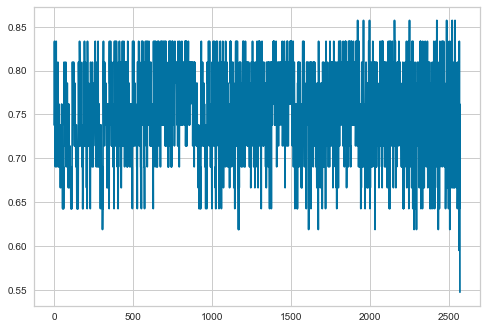

In [139]:
plt.plot(scores)
plt.show()

In [149]:
print(f'Highest scores of {np.max(scores):.3} occurr at indices: '
      f'{np.argwhere(scores == np.max(scores)).flatten().tolist()}.')

Highest scores of 0.857 occurr at indices: [1920, 1957, 1995, 2153, 2248, 2421, 2483, 2518, 2536].


In [160]:
# Put values into dataframe to look at optimal weights for classifiers
                                                               
df_scores = pd.DataFrame()
df_scores['scores'] = scores
df_scores['dtc'] = w1
df_scores['rfc'] = w2
df_scores['etc'] = w3
df_scores['lgbm'] = w4
df_scores['gbc'] = w5
df_scores['knn'] = w6

# Best scores

how_many = len(np.argwhere(scores == np.max(scores)).flatten().tolist())
best_score = df_scores.sort_values(by=['scores'], ascending=False).head(how_many)
best_score

,scores,dtc,rfc,etc,lgbm,gbc,knn
2248,0.857143,0.4,0.0,0.3,0.0,0.3,0.0
2421,0.857143,0.5,0.1,0.0,0.0,0.4,0.0
1920,0.857143,0.3,0.0,0.0,0.1,0.0,0.6
2518,0.857143,0.6,0.2,0.1,0.0,0.1,0.0
2536,0.857143,0.7,0.1,0.0,0.0,0.0,0.2
1957,0.857143,0.3,0.0,0.1,0.2,0.0,0.4
2153,0.857143,0.3,0.3,0.1,0.1,0.0,0.2
1995,0.857143,0.3,0.0,0.3,0.1,0.1,0.2
2483,0.857143,0.6,0.0,0.1,0.0,0.0,0.3


In [172]:
for c in best_score.columns[1:]:
    print('Count for',c,f'is {best_score[best_score[c] > 0][c].count()}')

Count for dtc is 9
Count for rfc is 4
Count for etc is 6
Count for lgbm is 4
Count for gbc is 4
Count for knn is 6


From the weights we see that the Decision Tree is always present, and usually has the largest weight.  
Next most common are the Extra Trees and K Neighbors classifiers. However, the weight for K Neighbors is usually greater than Extra Trees.  
For these reasons, we will choose the last row as our set of weights.

In [175]:
# Final Voting Classifier

vclf_fin = VotingClassifier(estimators=[('est1', dtc), 
                                    ('est2', etc), 
                                    ('est3', knn)], 
                            voting = 'soft', 
                            weights=[0.6, 0.1, 0.3])

#Fit and predict

vclf_fin.fit(Xboot, yboot)
vclf_fin_pred = vclf_fin.predict(Xt)

# Classification report

print(classification_report(yt, vclf_fin_pred))

# Confusion matrix

confusion_matrix = pd.crosstab(yt, 
                               vclf_fin_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

              precision    recall  f1-score   support

           0       0.82      0.86      0.84        21
           1       0.85      0.81      0.83        21

    accuracy                           0.83        42
   macro avg       0.83      0.83      0.83        42
weighted avg       0.83      0.83      0.83        42



Predicted,0,1
Actual,,
0,18,3
1,4,17


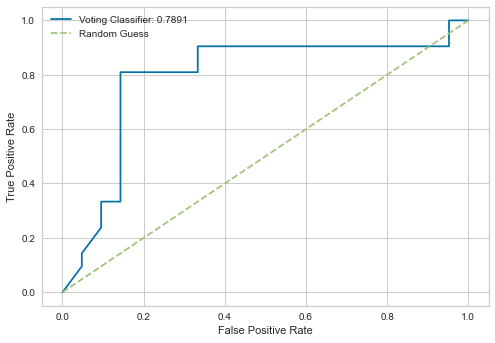

In [183]:
# Predict the probabilities for happy customers

pred_proba = vclf_fin.predict_proba(Xt)[:,1]

# Get the false and true positive rates

fpr, tpr, threshold = roc_curve(yt, pred_proba)

# Area under curve

roc_auc = auc(fpr, tpr)

# Plot  ROC curve

plt.plot(fpr, tpr)#, color = 'orange')
plt.plot([0,1], [0,1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend([f'Voting Classifier: {roc_auc:.4}', 'Random Guess'])
plt.show()

In [264]:
# Permutation test to determine and record feature importances

r = permutation_importance(vclf_fin, Xt, yt, n_repeats=30, random_state=9)

# Dictionary for features and importances
feat = {}  

# Carry out the permutation
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        feat[df_balanced3.columns[i]] = [r.importances_mean[i], r.importances_std[i]]

# Define function to grab survey question identifier

def survey(str):
    return str.split('_')[1]

# Dictionary with survey question ID and lambda values

sq_dict = {'time': time_lambda, 
           'price': price_lambda, 
           'courier': courier_lambda, 
           'app': app_lambda}

# Define inverse Yeo Johnson function

def inv_yj(num, lam):  
    return (num*lam + 1)**(1/lam) - 1
    
# Grab values for inverse Yeo Johnson transformation
print()
for k, v in feat.items():   
    # Get survey question identifier
    sq = survey(k) 
    # For floats, apply inverse transform
    try:
        try_lst = k.split('_')[-1].split('.')
        num = inv_yj(float('.'.join(try_lst)), sq_dict[sq])    
        print(f'{k:<35}'
              f'survey question rating: {int(num)}, '
              f'mean: {v[0]:.3f}'
              f' +/- {v[1]:.3f}')
    # For integers, no transform
    except:
        num = float(k.split('_')[-1])
        print(f'{k:<35}'
              f'survey question rating: {int(num)}, '
              f'mean: {v[0]:.3f}'
              f' +/- {v[1]:.3f}')


good_app_59.63653936085705         survey question rating: 4, mean: 0.133 +/- 0.052
on_time_62.81945769618666          survey question rating: 3, mean: 0.110 +/- 0.044
order_everything_4                 survey question rating: 4, mean: 0.102 +/- 0.022
order_everything_2                 survey question rating: 2, mean: 0.100 +/- 0.037
on_time_153.28731338999947         survey question rating: 4, mean: 0.083 +/- 0.029
on_time_3.726441732840231          survey question rating: 1, mean: 0.065 +/- 0.025
good_courier_12.661375235580175    survey question rating: 4, mean: 0.021 +/- 0.008


## Conclusion

We used a soft Voting Classifier that combined, in order of importance, a Decision Tree, a K Neighbors, and an Extra Trees classifier.  
This resulted in an accuracy of 83%, and F1-scores of 0.84 and 0.83 for the unhappy and happy customers, respectively.  
The most impactful features were the good_app (rating of 4 - just below the median), on_time (ratings 3 and 4 - below the median), and order_everything (ratings 2 and 4 - either side of the median).